In [1]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import svm
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

/home/vicky/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [3]:
def GaussianFilter(df, window_length):
    df1 = df
    
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    df1['AX1'] = gaussian_filter(df['AX1'], window_length)
    df1['AY1'] = gaussian_filter(df['AY1'], window_length)
    df1['AZ1'] = gaussian_filter(df['AZ1'], window_length)

    df1['GX1'] = gaussian_filter(df['GX1'], window_length)
    df1['GY1'] = gaussian_filter(df['GY1'], window_length)
    df1['GZ1'] = gaussian_filter(df['GZ1'], window_length)
    return df1

In [4]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [5]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        roll1 = atan(y/z)*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((z/((x*x + z*z)**(1/2))))*57.3
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
    
    df['orientX'] = pitch
    df['orientY'] = roll
    df['orientZ'] = yaw

In [6]:
def getQuat(df):

        """ Given 3 orientation angles, compute the quaternion. """

        yaw   = df['orientZ'] / 2. * np.pi / 180
        roll  = df['orientX'] / 2. * np.pi / 180
        pitch = df['orientY'] / 2. * np.pi / 180

        w =  np.cos(roll) * np.cos(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.sin(pitch) * np.sin(yaw)

        x =  np.sin(roll) * np.cos(pitch) * np.cos(yaw) - \
                np.cos(roll) * np.sin(pitch) * np.sin(yaw)

        y =  np.cos(roll) * np.sin(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.cos(pitch) * np.sin(yaw)

        z =  np.cos(roll) * np.cos(pitch) * np.sin(yaw) - \
                np.sin(roll) * np.sin(pitch) * np.cos(yaw)

        return w, x, y, z

In [7]:
"""
Rotate a 3D vector using the axis-angle method (quaternions).
"""

import numpy as np


def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return v

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    return w, x, y, z

def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w) * 2.0
    return normalize(v), theta

In [8]:
def get_rotation(quatern, vector):
    rotaedvector = []
    for i in range(vector.shape[0]):
        rotaedvector.append(qv_mult(tuple(quatern[i,:]), tuple(vector[i,:])))
    return np.array(rotaedvector)

In [9]:
def rotate(df):
    features = ['A', 'G']
    quaternion = df[['quaternionW', 'quaternionX',
                     'quaternionY','quaternionZ']].values
    
    for f in features:
        xyzlist = [f + 'X', f + 'Y', f + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = get_rotation(quaternion, xyz)
        df[f + 'X1'] = xyz_rotated[:,0]
        df[f + 'Y1'] = xyz_rotated[:,1]
        df[f + 'Z1'] = xyz_rotated[:,2]
        

In [10]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [11]:
def data_preprocessing(df):
#     df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 10
    Yaw_Roll_Pitch(df)
    qw, qx, qy, qz = getQuat(df)
    df['quaternionW'] = qw
    df['quaternionX'] = qx
    df['quaternionY'] = qy
    df['quaternionZ'] = qz
    rotate(df)
    df = GaussianFilter(df, 10)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df
    
    
    
    
    

In [12]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
#         gx = df['GX'].values[i: i + N_TIME_STEPS]
#         gy = df['GY'].values[i: i + N_TIME_STEPS]
#         gz = df['GZ'].values[i: i + N_TIME_STEPS]
#         ax = df['AX'].values[i: i + N_TIME_STEPS]
#         ay = df['AY'].values[i: i + N_TIME_STEPS]
#         az = df['AZ'].values[i: i + N_TIME_STEPS]
        
        gx1 = df['GX1'].values[i: i + N_TIME_STEPS]
        gy1 = df['GY1'].values[i: i + N_TIME_STEPS]
        gz1 = df['GZ1'].values[i: i + N_TIME_STEPS]
        ax1 = df['AX1'].values[i: i + N_TIME_STEPS]
        ay1 = df['AY1'].values[i: i + N_TIME_STEPS]
        az1 = df['AZ1'].values[i: i + N_TIME_STEPS]
        label = "ST"
        segments.append([ax1, ay1, az1, gx1, gy1, gz1])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [13]:
# def segmentation(df, N_TIME_STEPS):
    
#     N_FEATURES = 1
#     step = 50
#     segments = []
#     features = ['AX','AY','AZ','GX','GY','GZ']
#     labels = []
#     for i in range(0, len(df) - N_TIME_STEPS, step):
#         for j in features:
#             s = df[j].values[i: i + N_TIME_STEPS]
#             segments.append(s)
        
# #         gy = df['GY'].values[i: i + N_TIME_STEPS]
# #         gz = df['GZ'].values[i: i + N_TIME_STEPS]
# #         ax = df['AX'].values[i: i + N_TIME_STEPS]
# #         ay = df['AY'].values[i: i + N_TIME_STEPS]
# #         az = df['AZ'].values[i: i + N_TIME_STEPS]
#         label = "ST"
# #         segments.append([gx, gy, gz, ax, ay, az])
# #         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
#         labels.append(label)
#     return segments, labels

In [14]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [15]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if(ind-r>=0) else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if(ind-r>=0) else 0):(ind+r)])

        if(i>upper_bound):
            LB_sum=LB_sum+(i-upper_bound)**2
        elif(i<lower_bound):
            LB_sum=LB_sum+(i-lower_bound)**2

    return (LB_sum)**(1/2)

In [16]:
def loss_for_segments(segments, comp, feature):
    loss =[]
    labels=[]
    length = len(segments)
    for i in range(length):
        x = segments[i][feature]        
        dist = DTWDistance(x, comp, 50)
        print(i , '=>', dist)
#         if(dist<2):
#             this_label ='LT'
#         elif(dist>4):
#             this_label ='RT'
#         else:
#             this_label ='ST'
#         labels.append(this_label)
        loss.append(dist)
    
    return loss

In [17]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [18]:
# Function to map the colors as a list from the input list of x variables
def color_mapping(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [19]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)

    df = data_preprocessing(df)
    
    return df
    

In [20]:
  
path_acc = os.getcwd() + '/data/Bike0909/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Bike0909/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df= read_files(acc_files[0], gyro_files[0], 'bike')
n = len(df)
df = df[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df = pd.concat([df, df_this])
    print(df.shape)
df.reset_index(drop = True, inplace = True)
df.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-27-45/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-27-45/Gyroscope.csv
len of this file  (1602, 28)
len of this file  (752, 28)
(1504, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-56-06/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-56-06/Gyroscope.csv
len of this file  (1208, 28)
len of this file  (358, 28)
(1862, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-35-20/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-35-20/Gyroscope.csv
len of this file  (1626, 28)
len of this file  (776, 28)
(2638, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-43-19/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_23-05-22/Gyroscope.csv
len of this 

len of this file  (1632, 28)
len of this file  (782, 28)
(23108, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-49-15/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-32-07/Gyroscope.csv
len of this file  (1616, 28)
len of this file  (766, 28)
(23874, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-55-22/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_23-04-29/Gyroscope.csv
len of this file  (1311, 28)
len of this file  (461, 28)
(24335, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-02-43/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-04-26/Gyroscope.csv
len of this file  (1516, 28)
len of this file  (666, 28)
(25001, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-51-34/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/hum

AX        AY        AZ        GX        GY        GZ activity  \
0 -0.103734 -0.452977 -0.162621  0.005212  0.034370 -0.019772     bike   
1 -0.101174 -0.454834 -0.164125  0.003043  0.034571 -0.019437     bike   
2 -0.101477 -0.453014 -0.162729  0.001505  0.034501 -0.018903     bike   
3 -0.104794 -0.447808 -0.158758  0.000628  0.034175 -0.018184     bike   
4 -0.111142 -0.439595 -0.152590  0.000408  0.033619 -0.017292     bike   

     orientX    orientY    orientZ    ...          GY1       GZ1      mAcc  \
0 -23.267753  46.670557 -40.281074    ...     0.037462  0.019026 -0.239778   
1 -21.061002 -53.828436  39.950606    ...     0.036959  0.017930 -0.240044   
2 -71.995097  58.901900  -9.404984    ...     0.036394  0.016906 -0.239073   
3 -10.875999 -71.447541  40.570067    ...     0.035785  0.015954 -0.237120   
4  55.026093  -3.354744  29.797703    ...     0.035138  0.015084 -0.234442   

      mGyro       fAX       fAY       fAZ       fGX       fGY       fGZ  
0  0.006603 -0.324518 -0.307035 -0.360753 -0.324518 -0.307035 -0.360753  
1  0.006059  0.909610  0.862321  1.008052  0.909610  0.862321  1.008052  
2  0.005701 -0.324412 -0.308552 -0.361268 -0.324412 -0.308552 -0.361268  
3  0.005540  0.905068  0.856247  1.001210  0.905068  0.856247  1.001210  
4  0.005578 -0.327199 -0.307226 -0.359718 -0.327199 -0.307226 -0.359718  

[5 rows x 28 columns]

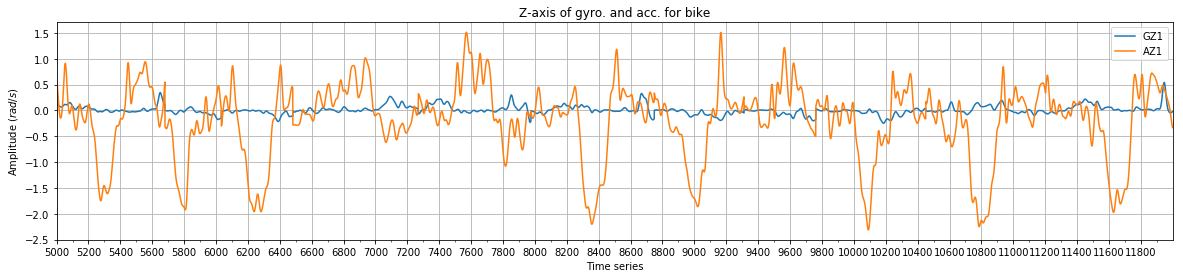

In [25]:

s = 5000
m = s + 7000
fig, ax = plt.subplots()
df[['GZ1','AZ1']][s:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. and acc. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
# n = len(df[s:m])
major_ticks = np.arange(s, m, 200)
minor_ticks = np.arange(s, m, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)


/home/vicky/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


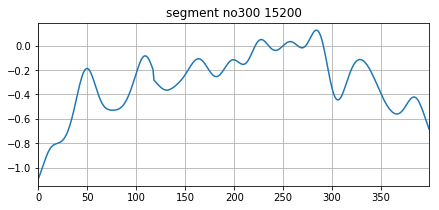

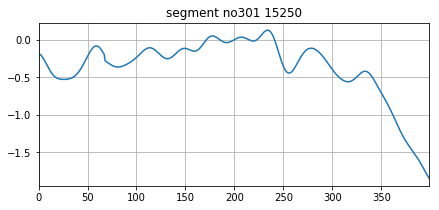

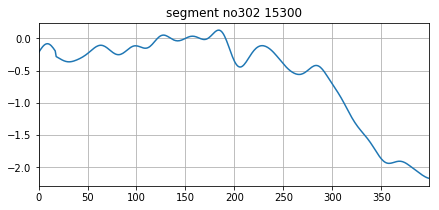

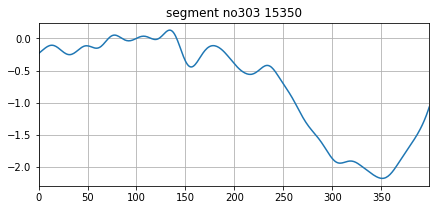

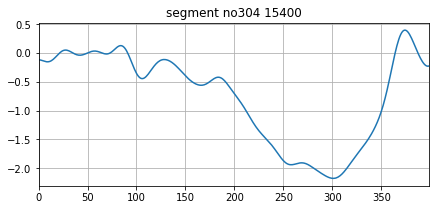

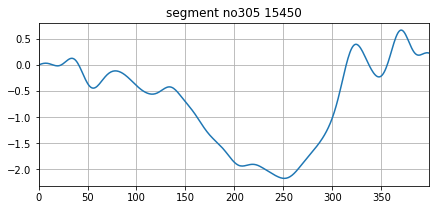

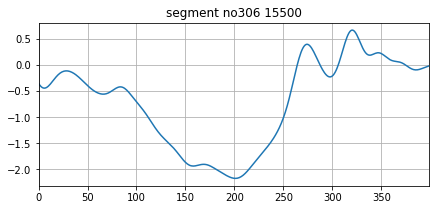

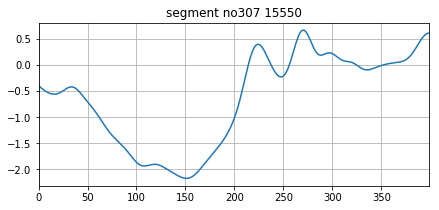

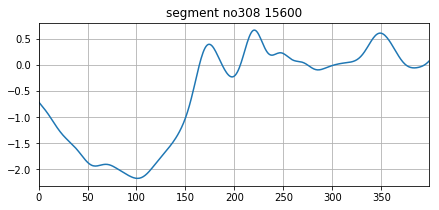

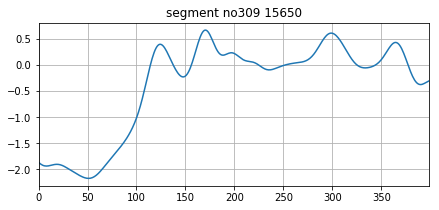

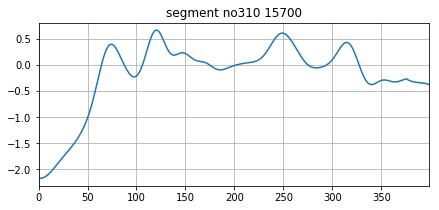

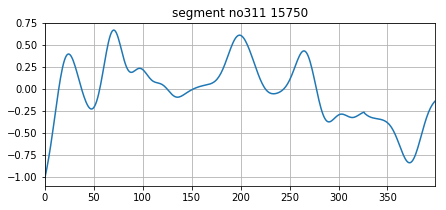

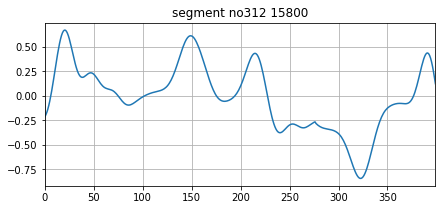

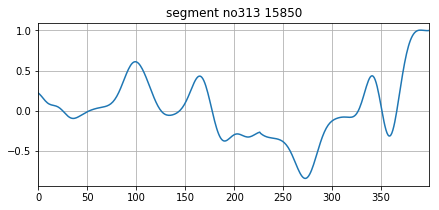

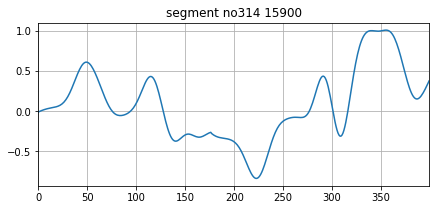

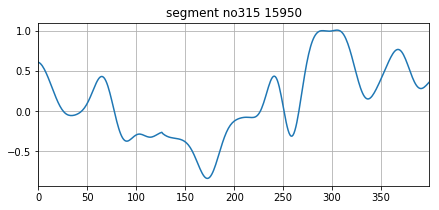

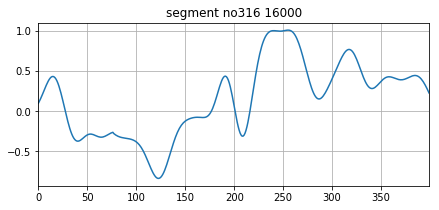

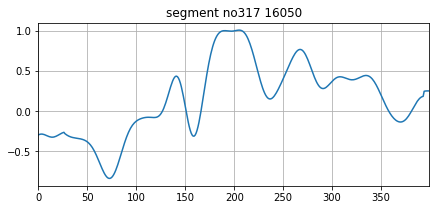

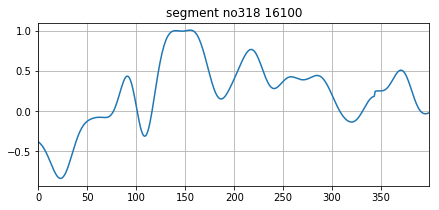

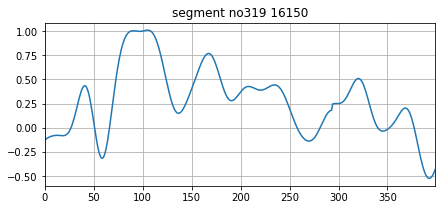

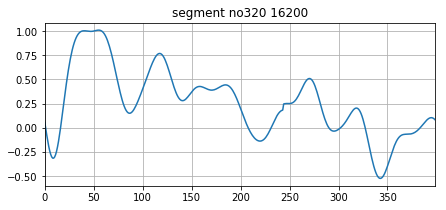

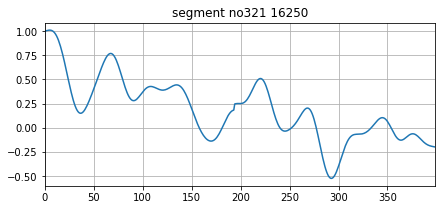

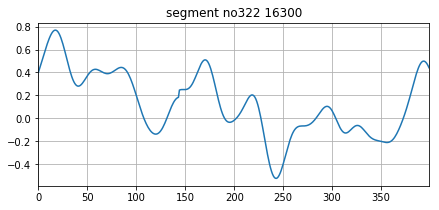

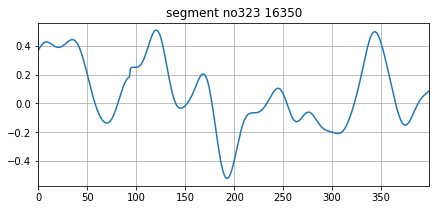

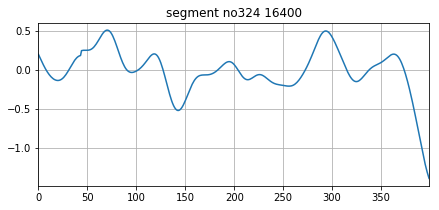

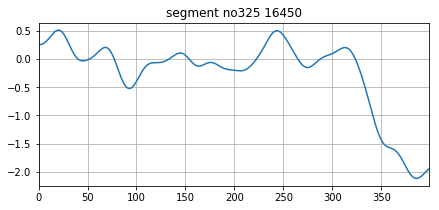

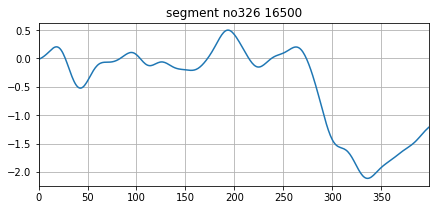

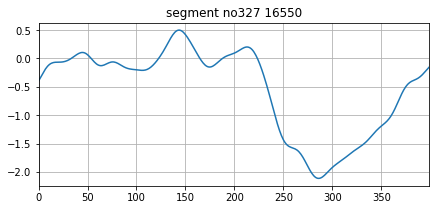

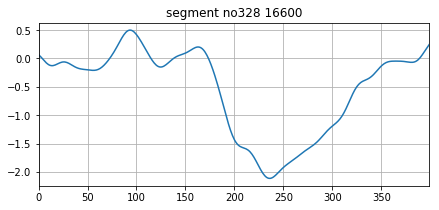

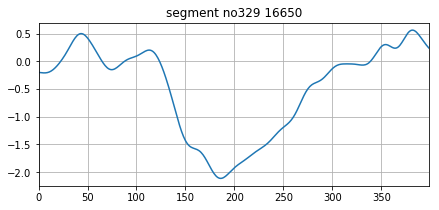

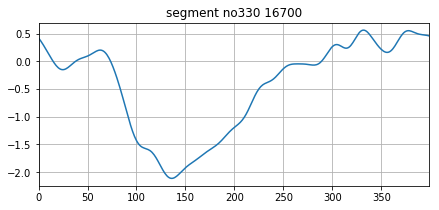

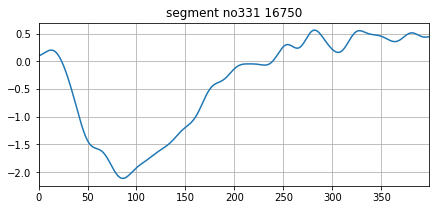

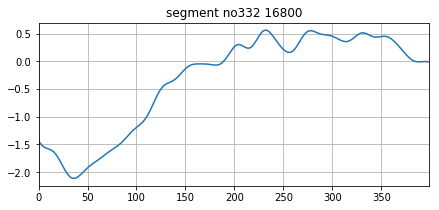

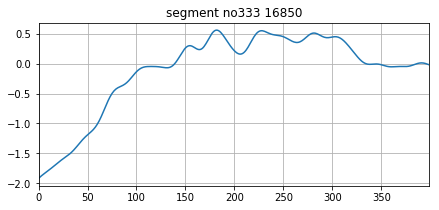

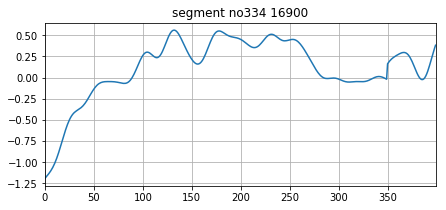

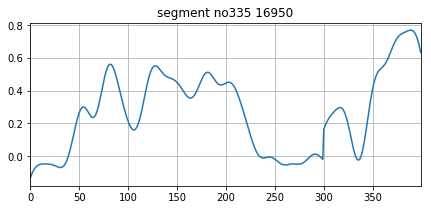

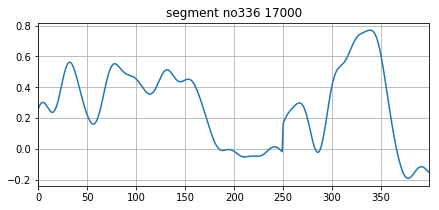

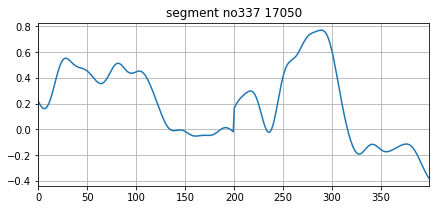

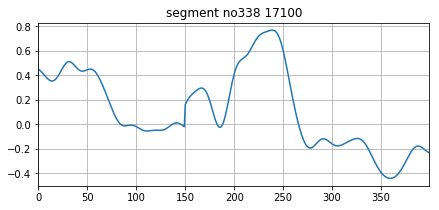

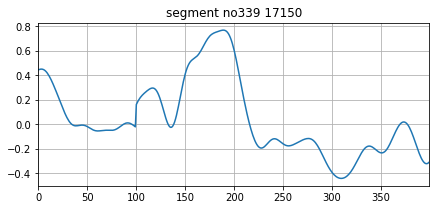

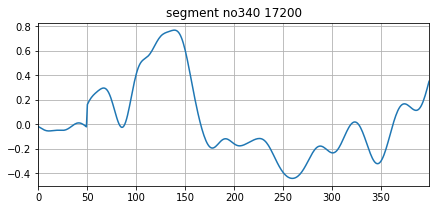

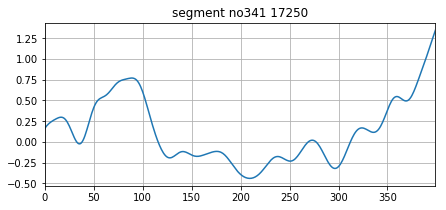

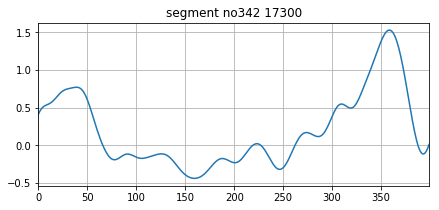

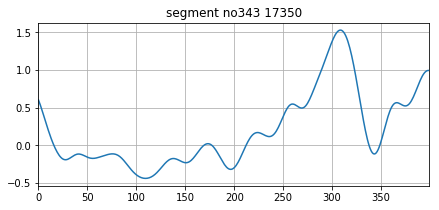

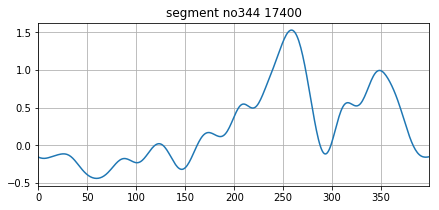

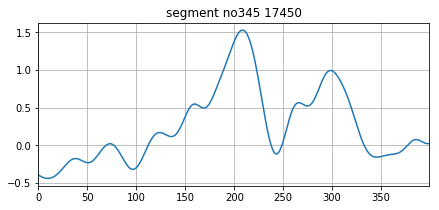

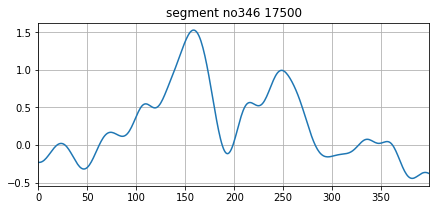

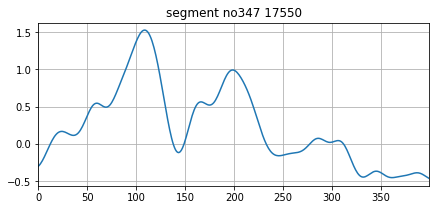

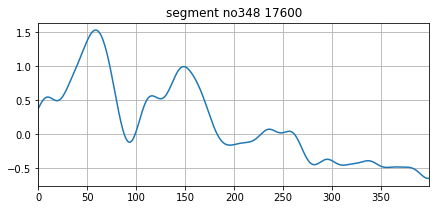

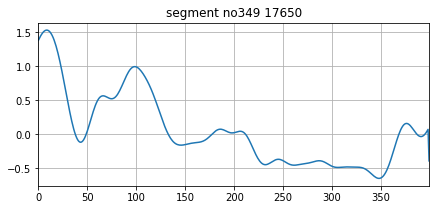

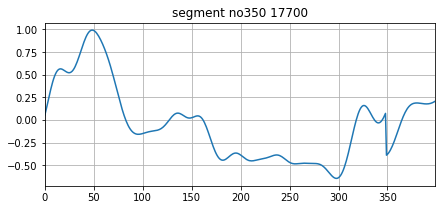

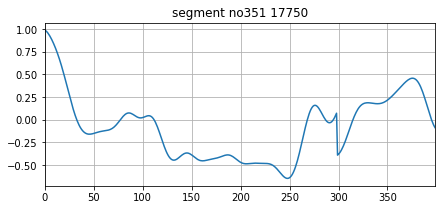

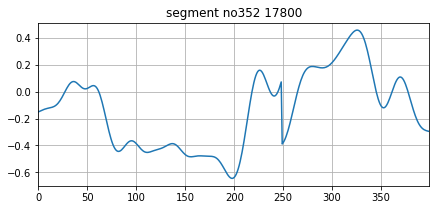

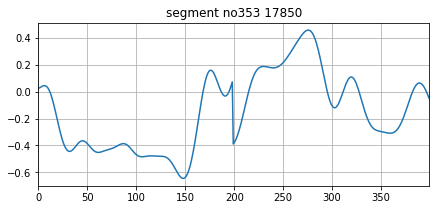

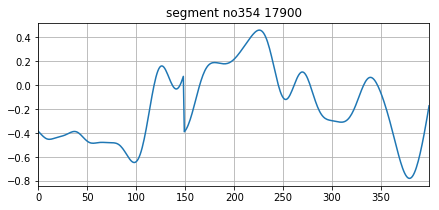

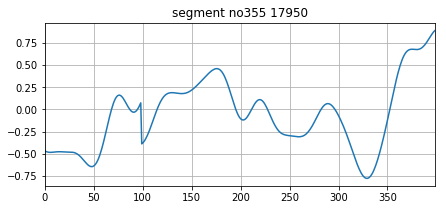

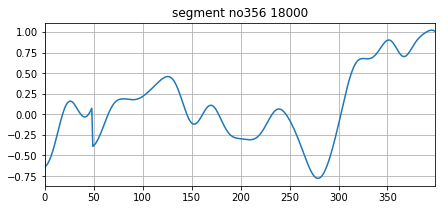

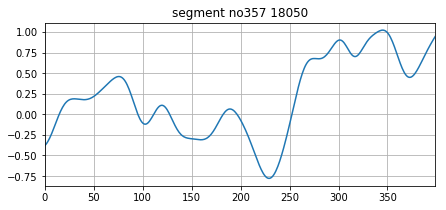

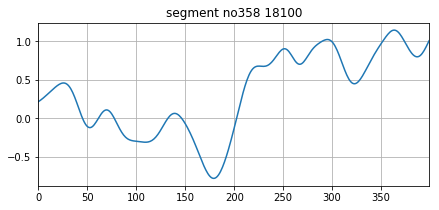

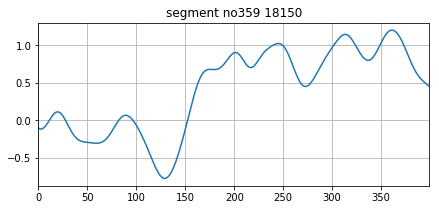

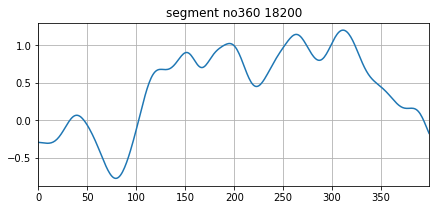

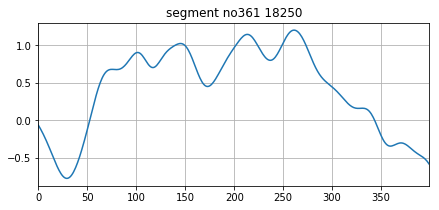

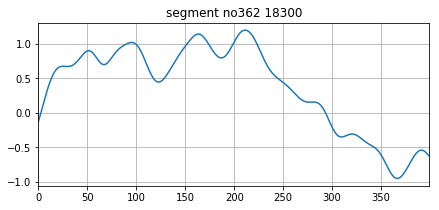

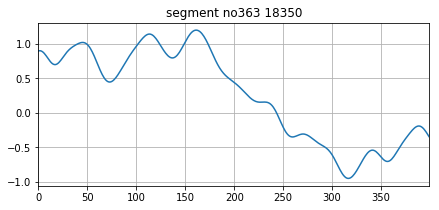

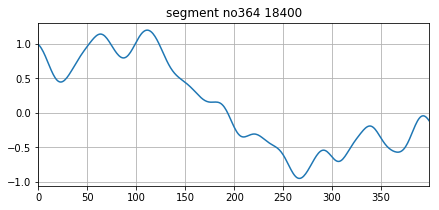

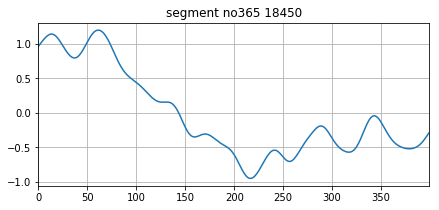

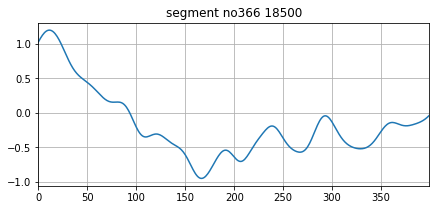

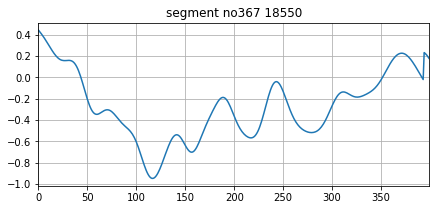

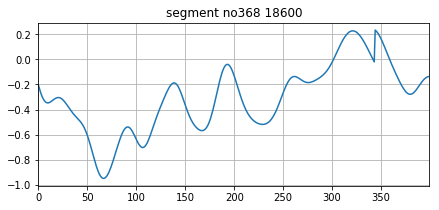

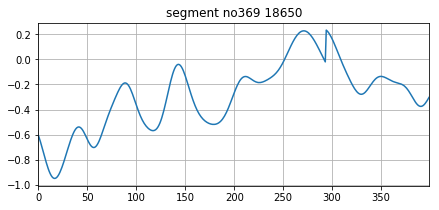

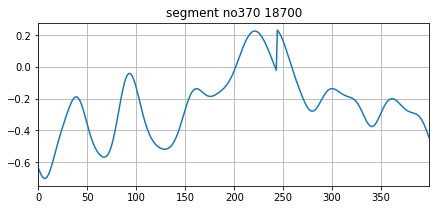

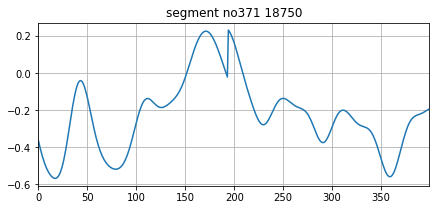

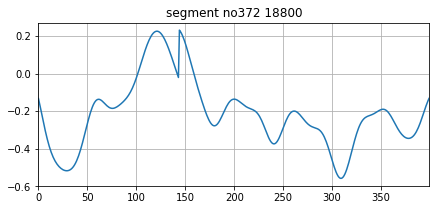

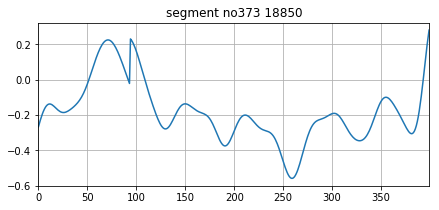

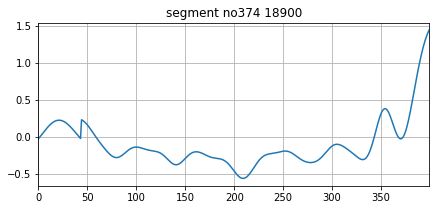

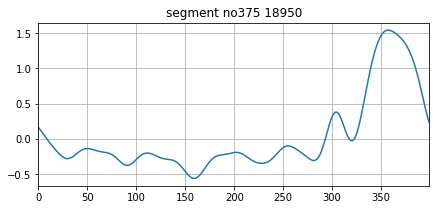

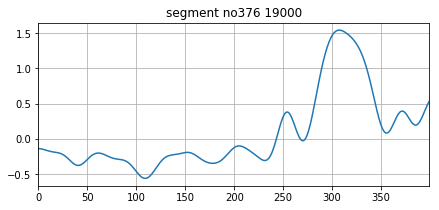

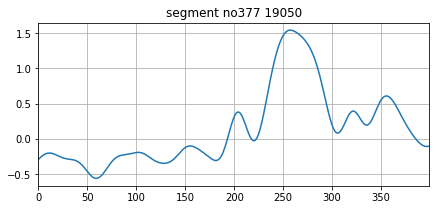

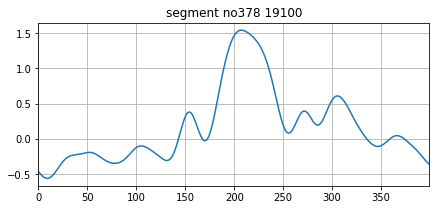

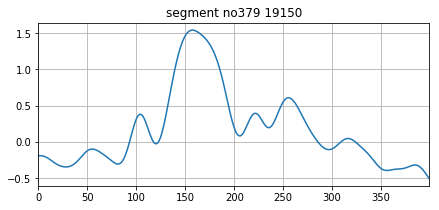

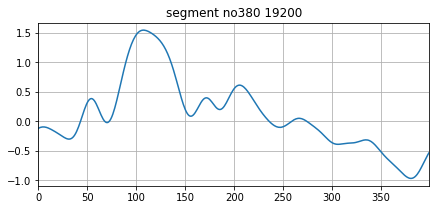

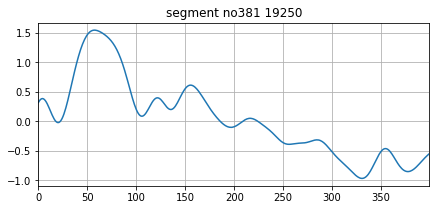

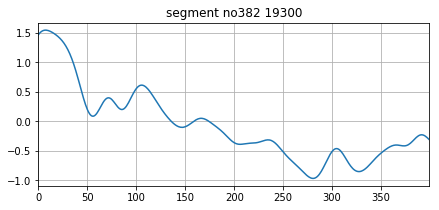

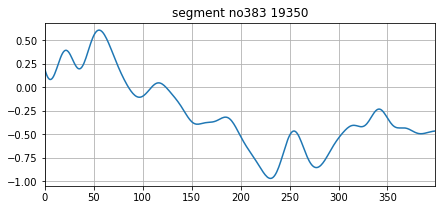

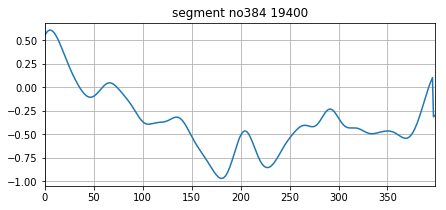

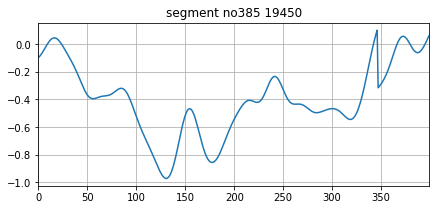

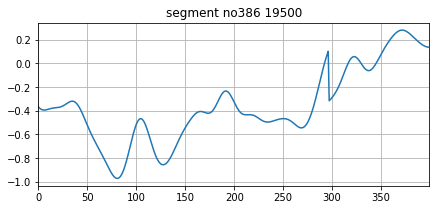

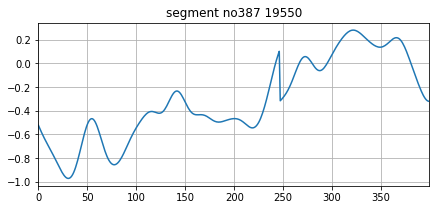

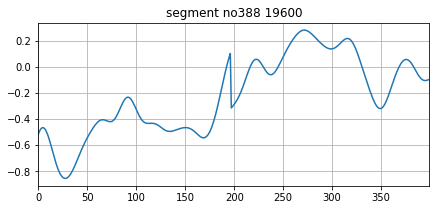

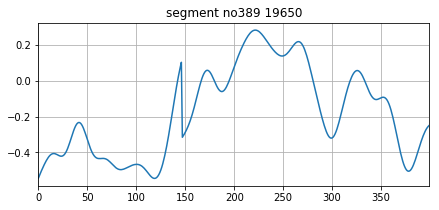

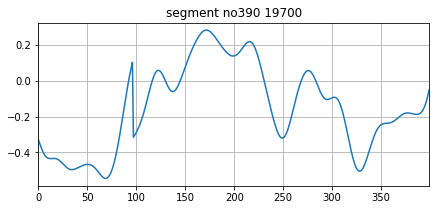

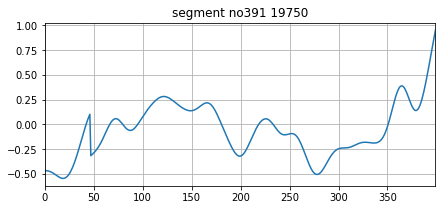

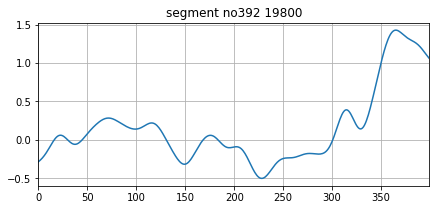

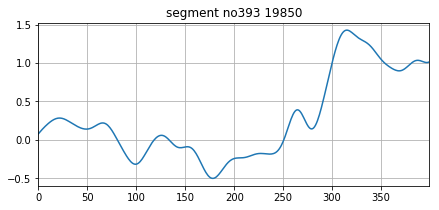

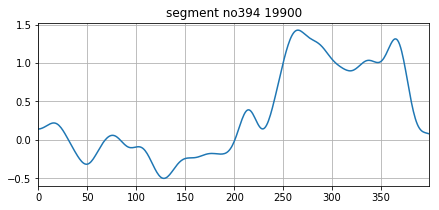

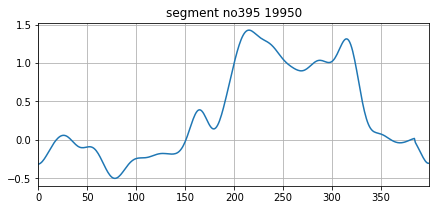

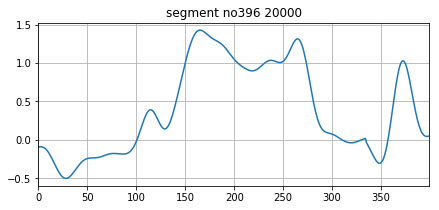

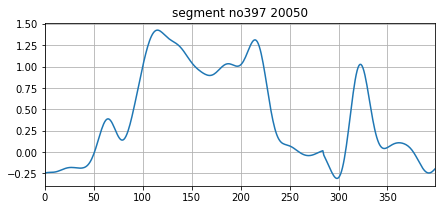

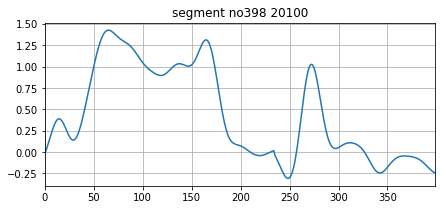

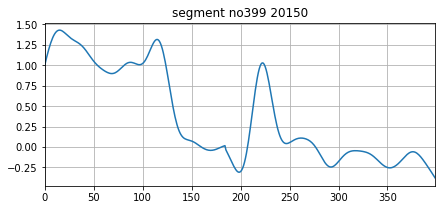

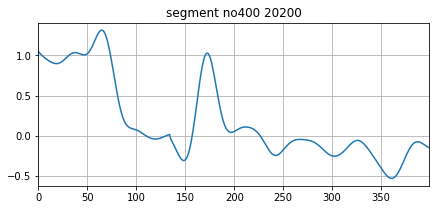

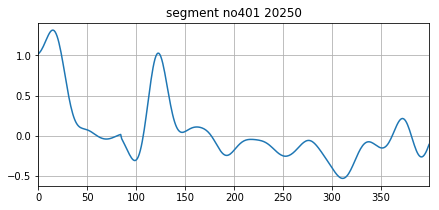

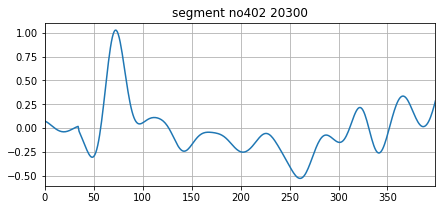

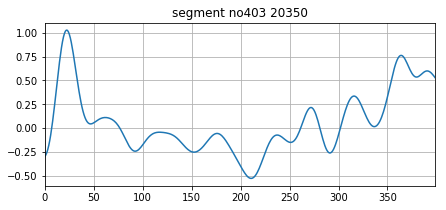

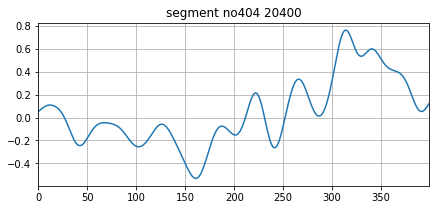

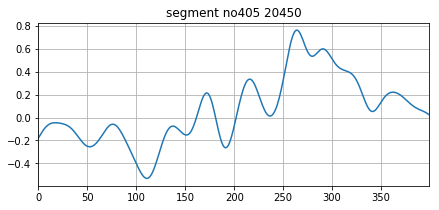

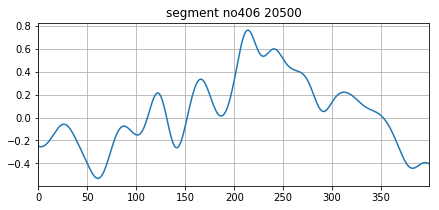

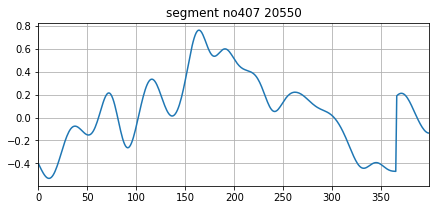

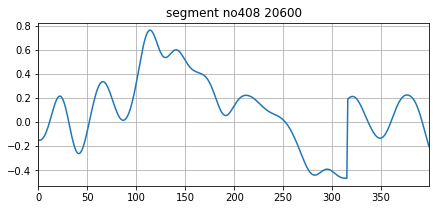

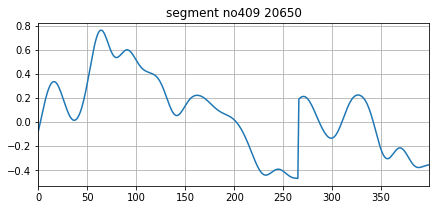

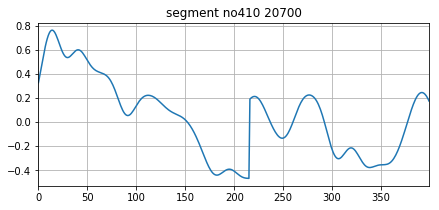

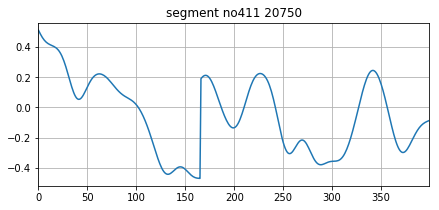

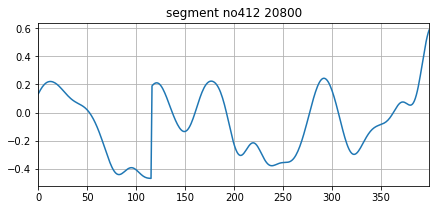

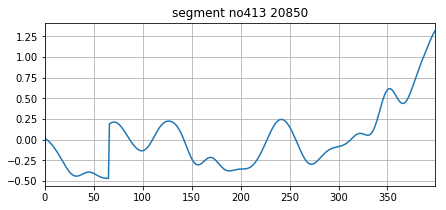

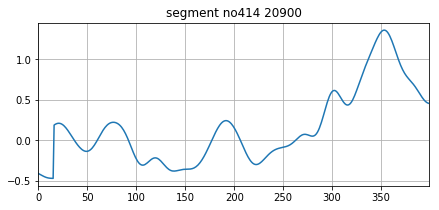

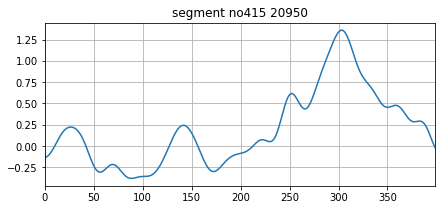

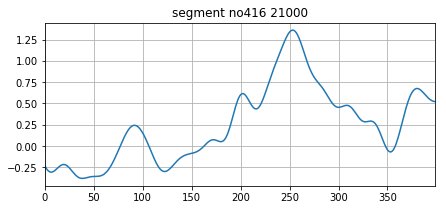

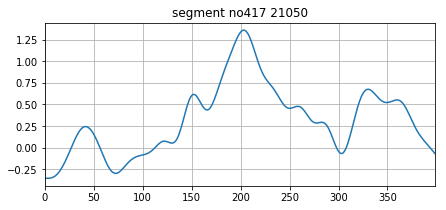

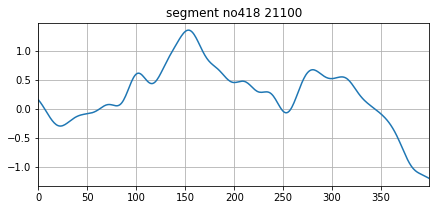

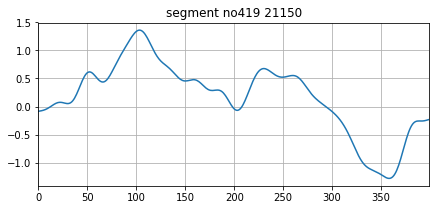

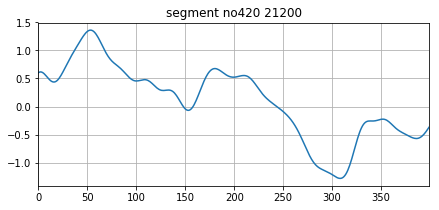

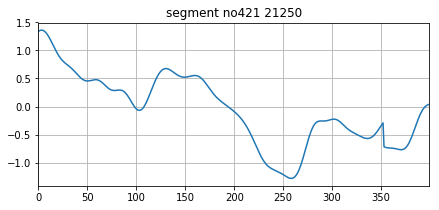

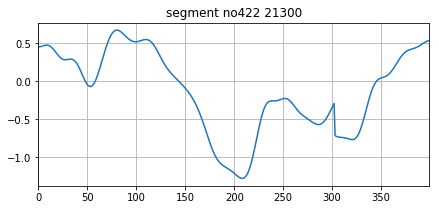

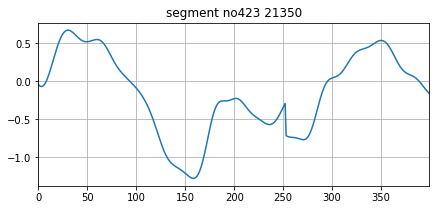

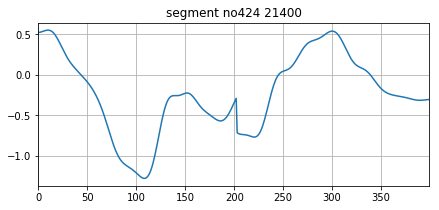

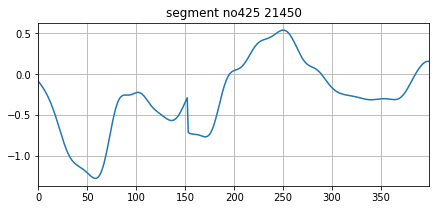

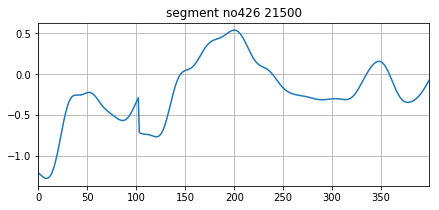

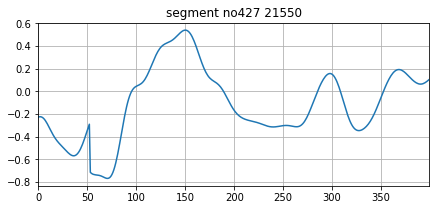

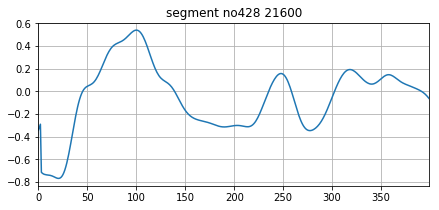

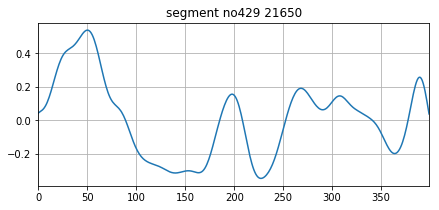

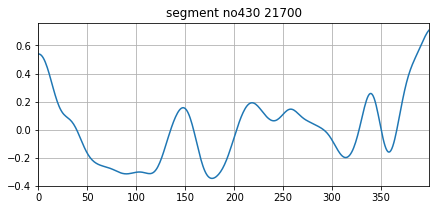

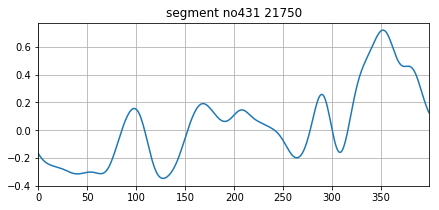

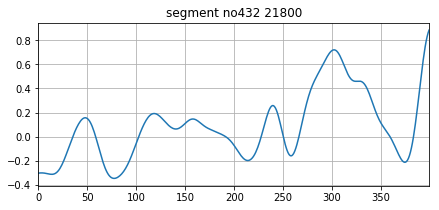

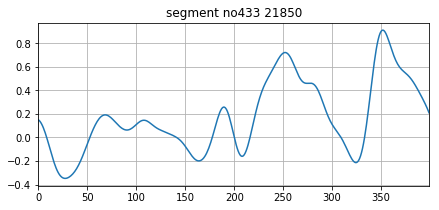

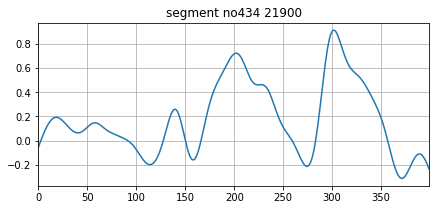

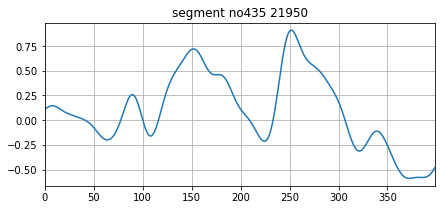

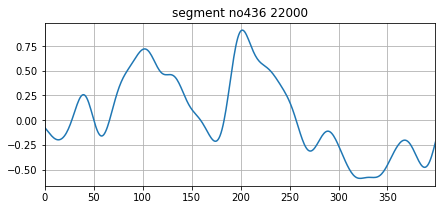

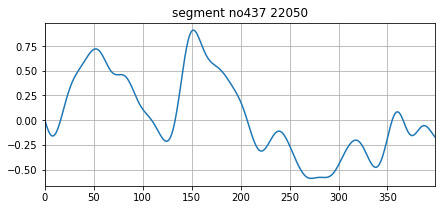

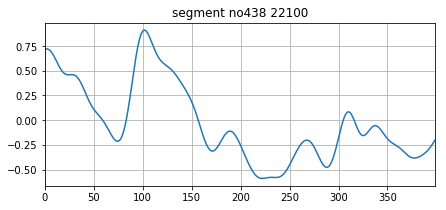

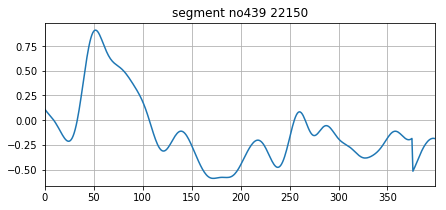

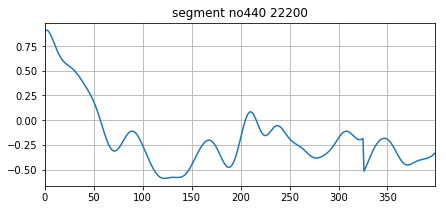

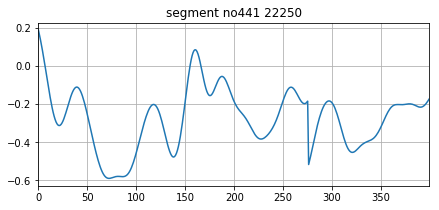

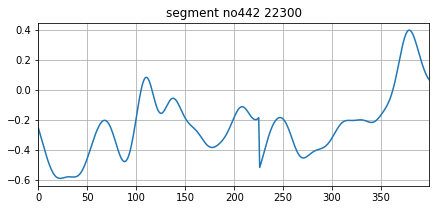

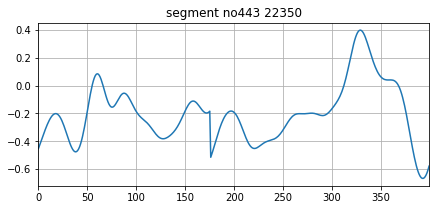

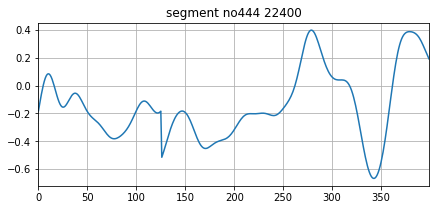

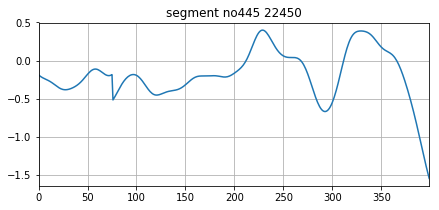

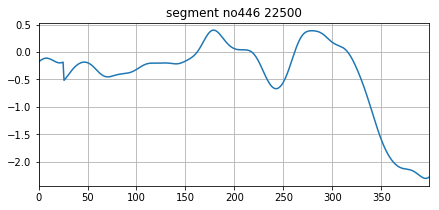

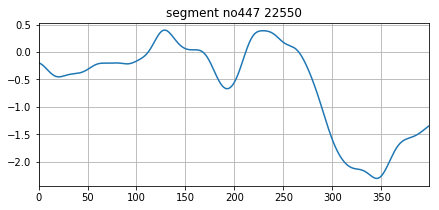

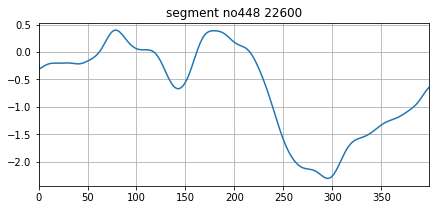

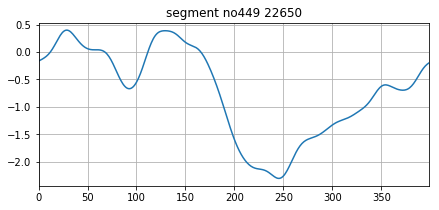

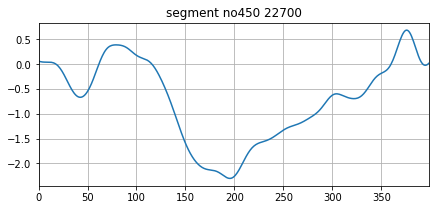

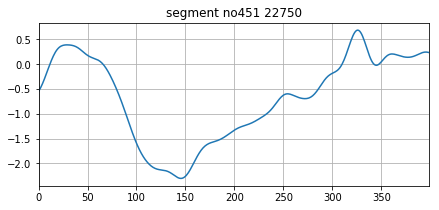

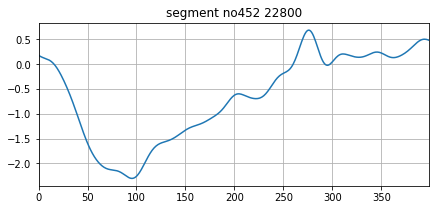

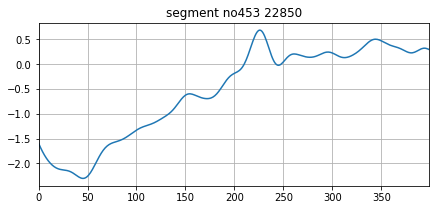

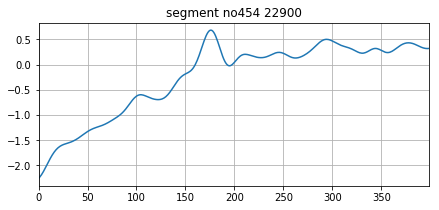

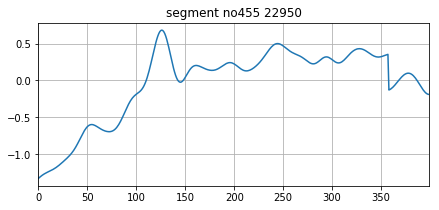

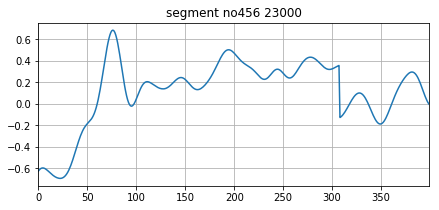

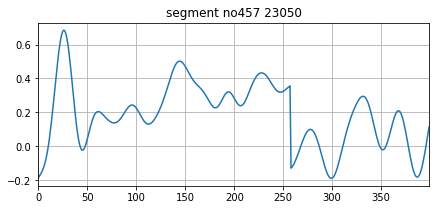

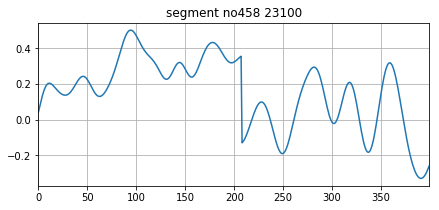

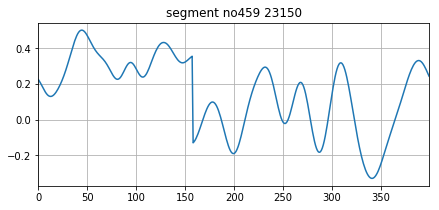

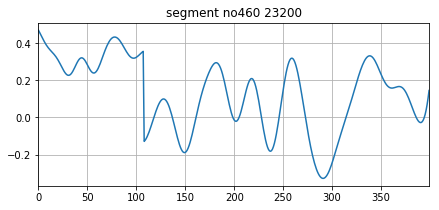

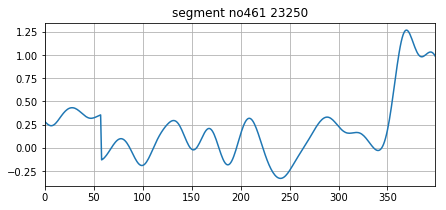

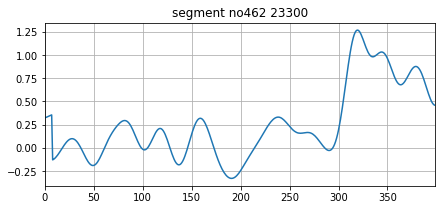

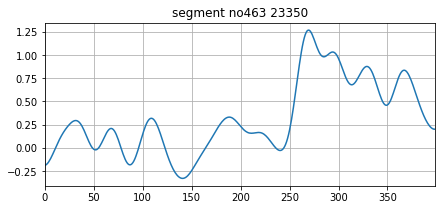

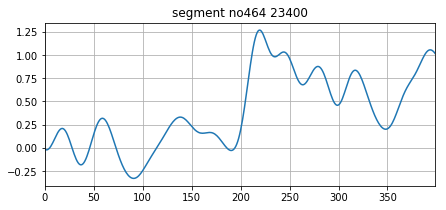

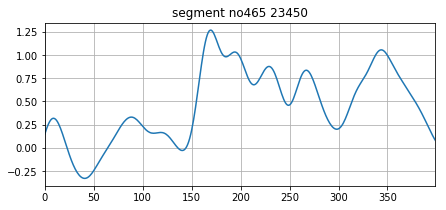

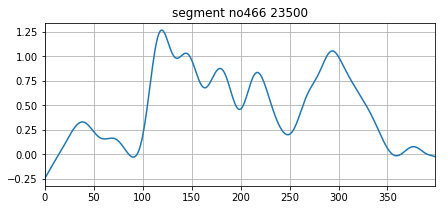

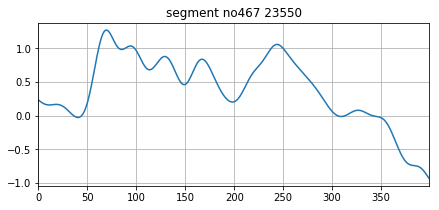

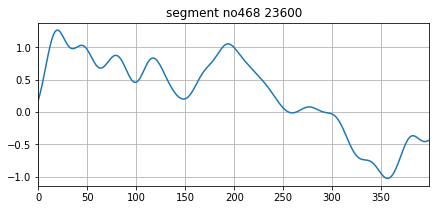

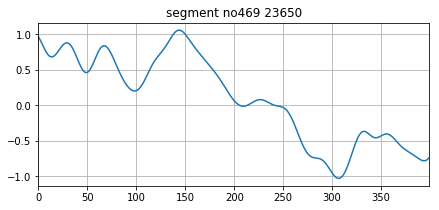

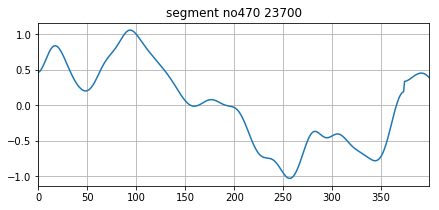

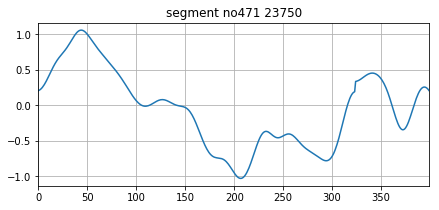

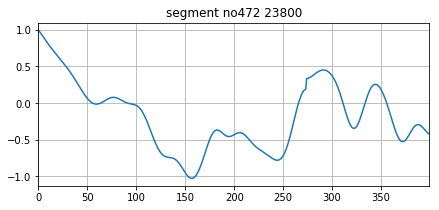

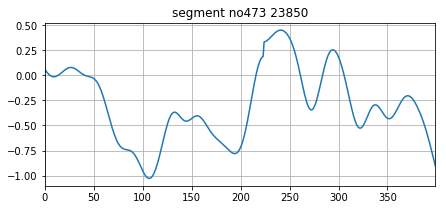

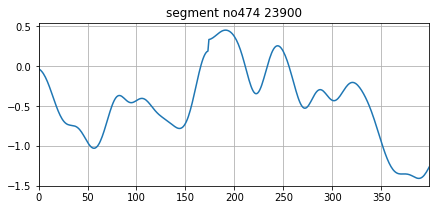

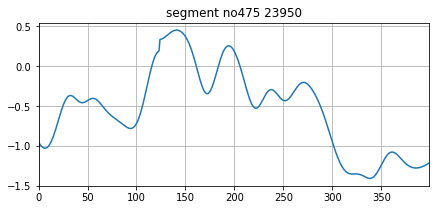

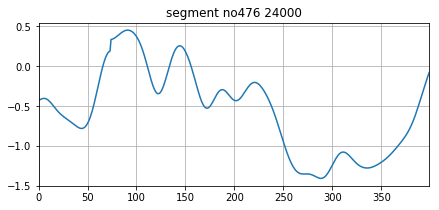

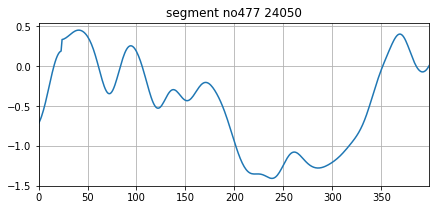

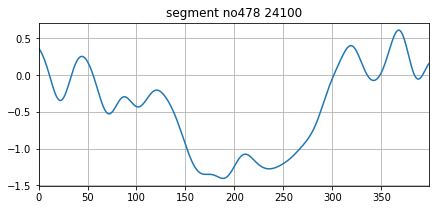

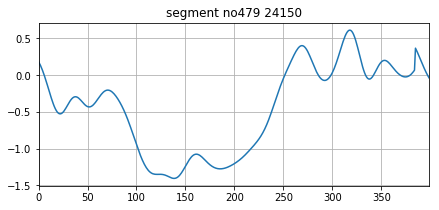

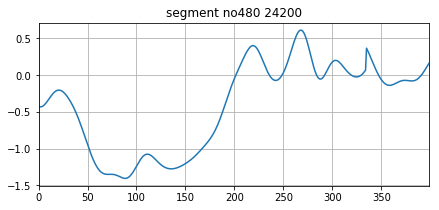

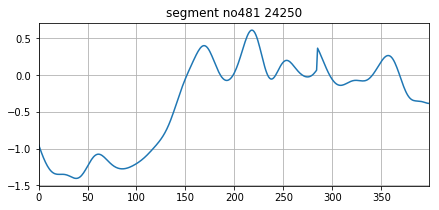

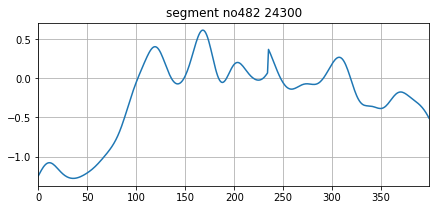

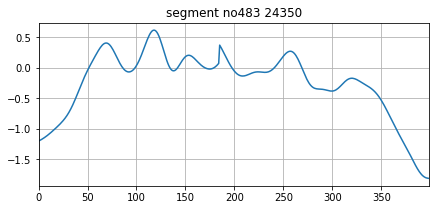

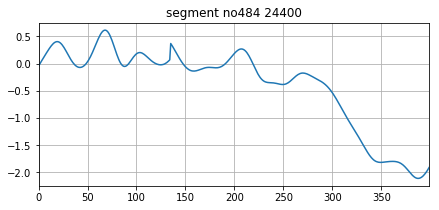

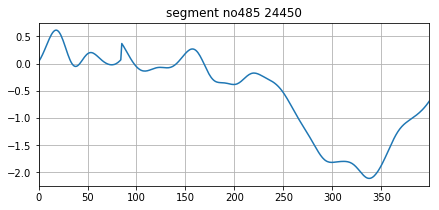

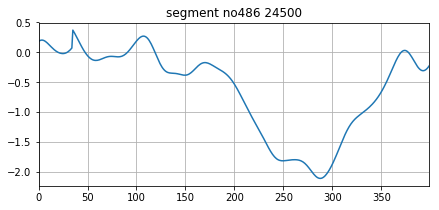

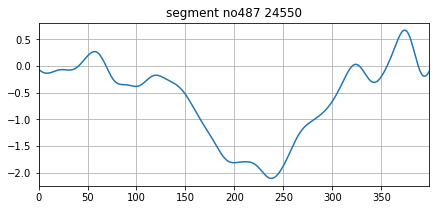

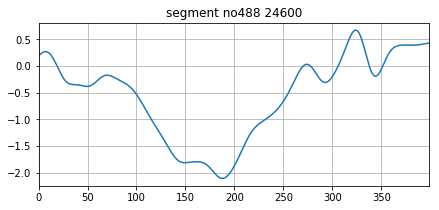

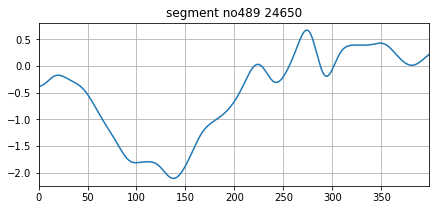

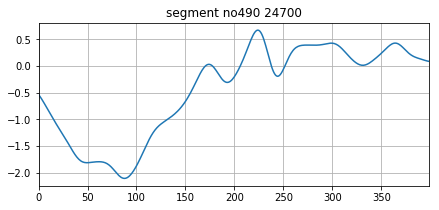

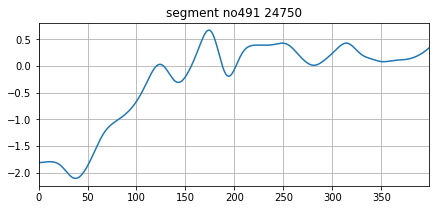

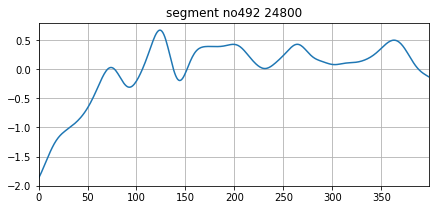

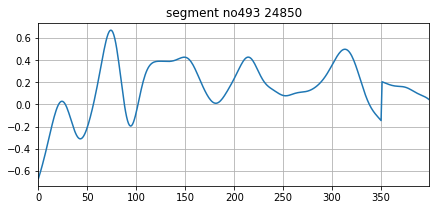

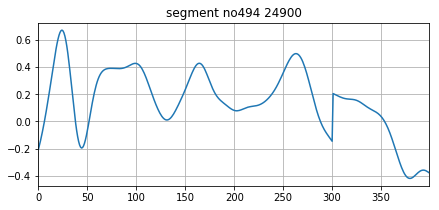

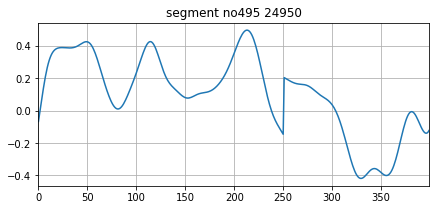

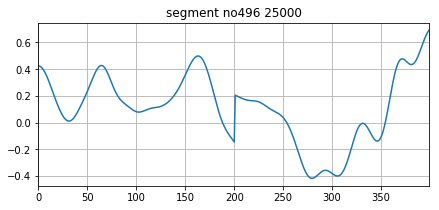

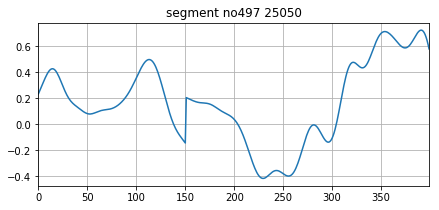

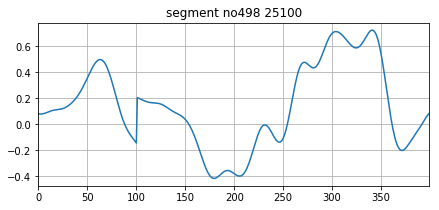

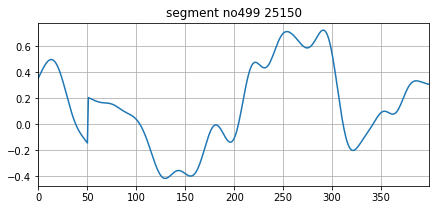

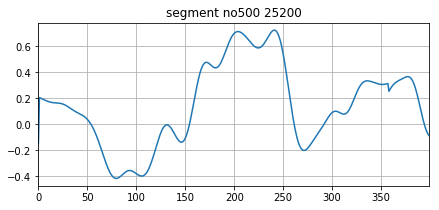

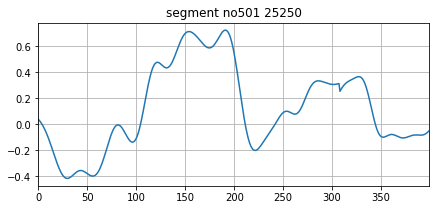

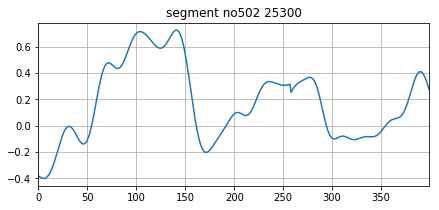

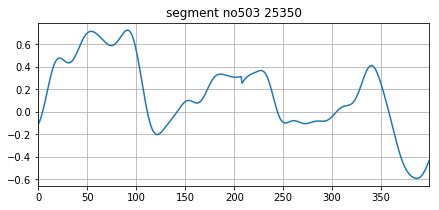

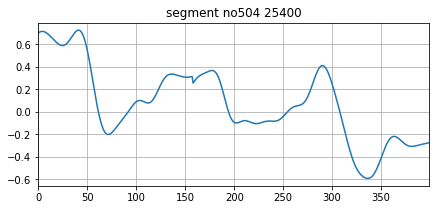

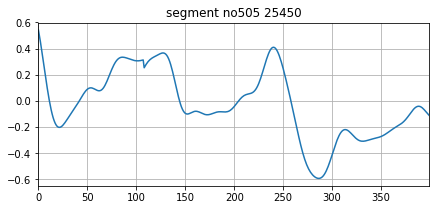

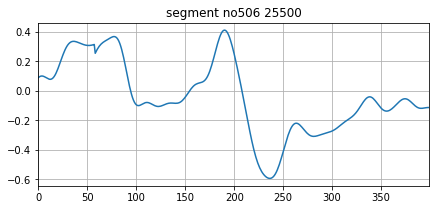

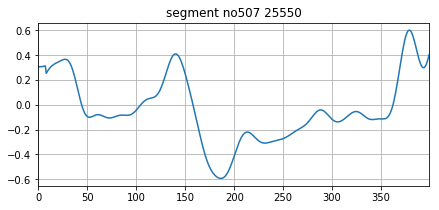

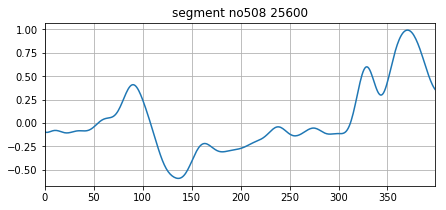

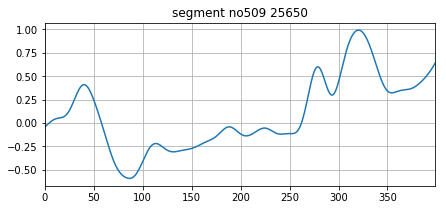

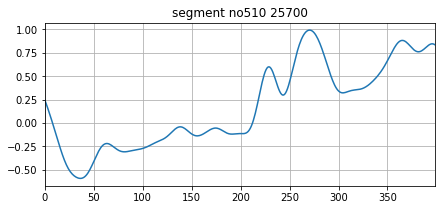

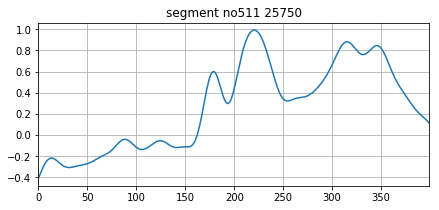

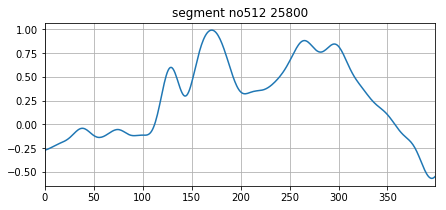

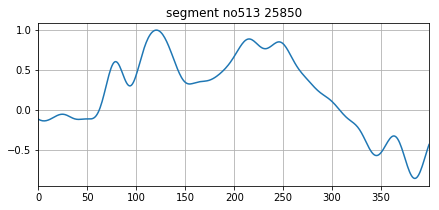

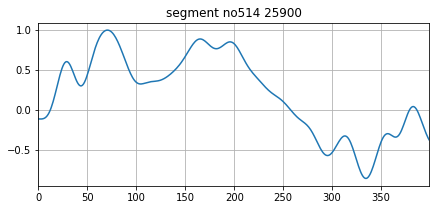

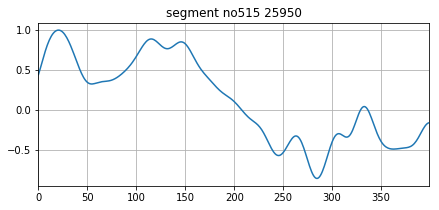

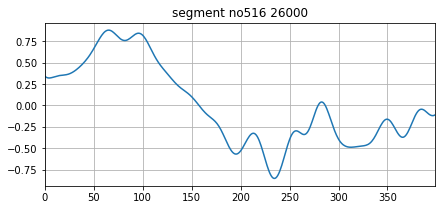

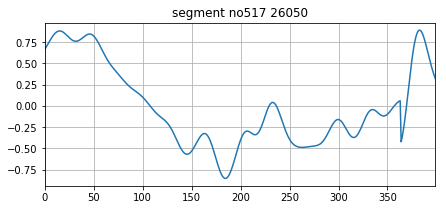

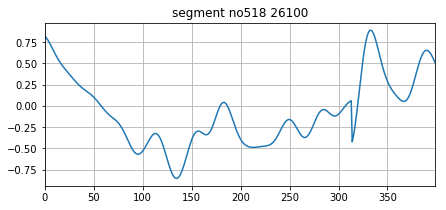

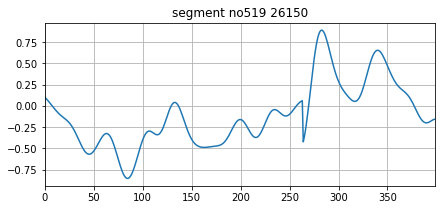

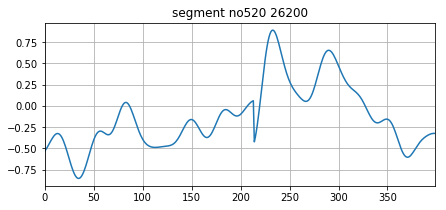

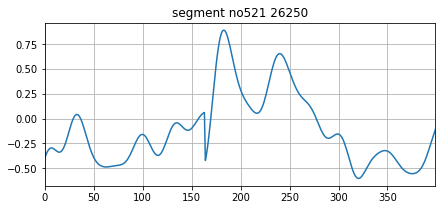

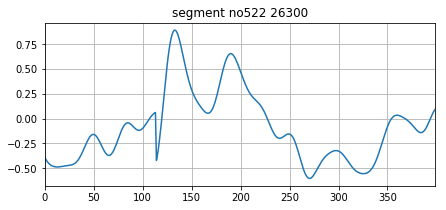

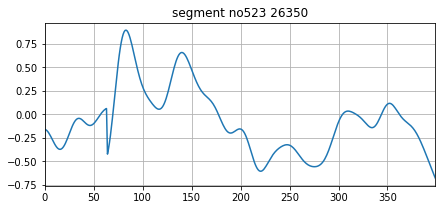

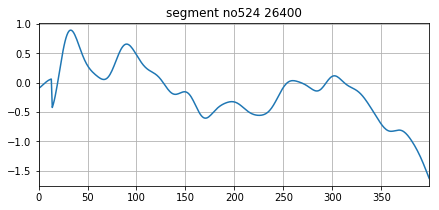

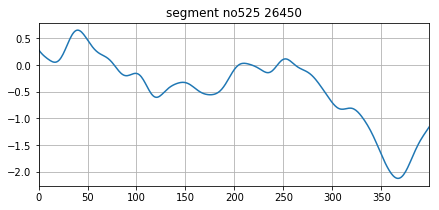

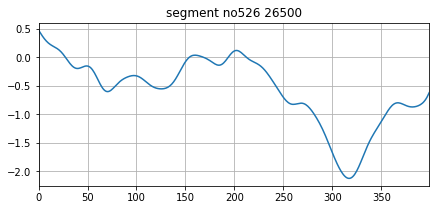

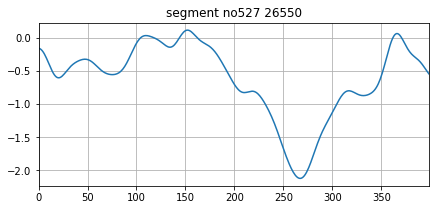

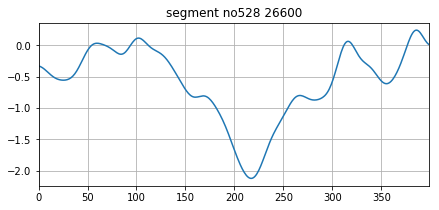

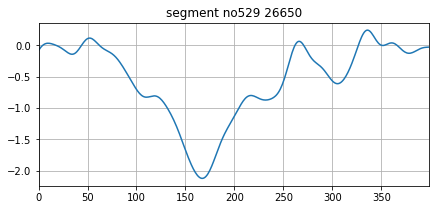

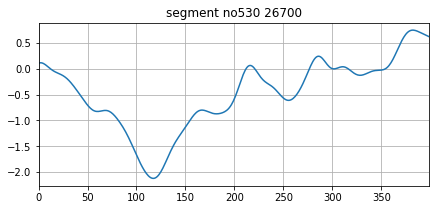

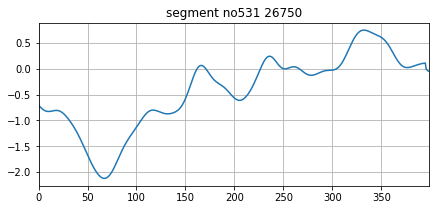

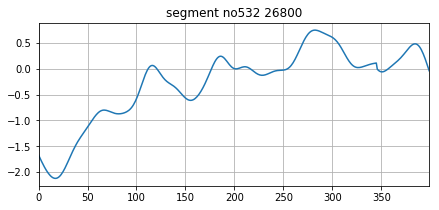

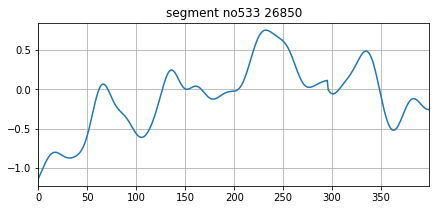

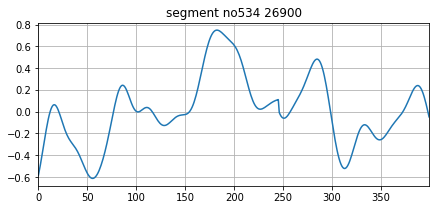

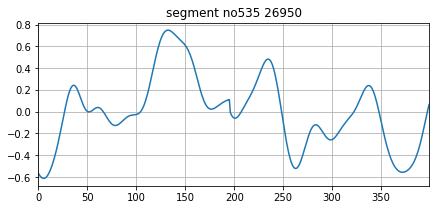

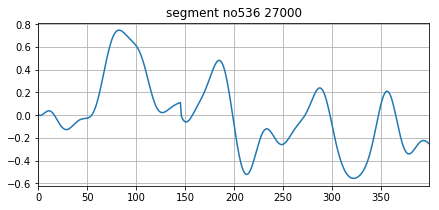

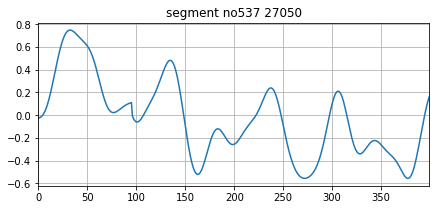

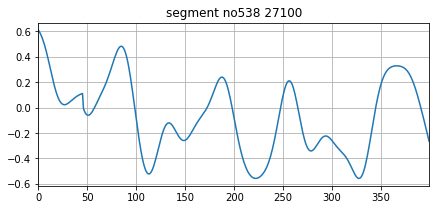

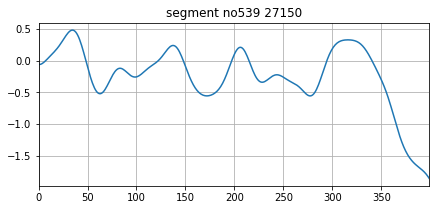

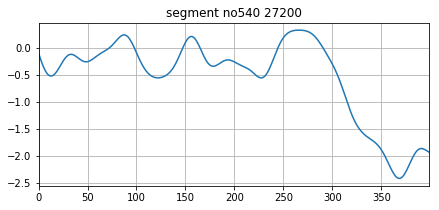

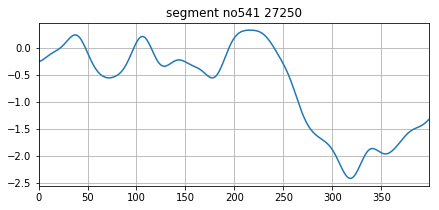

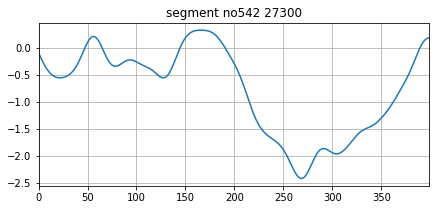

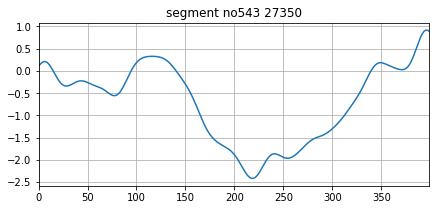

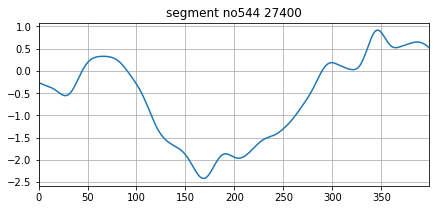

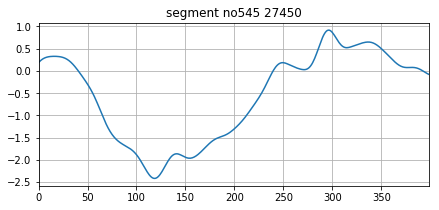

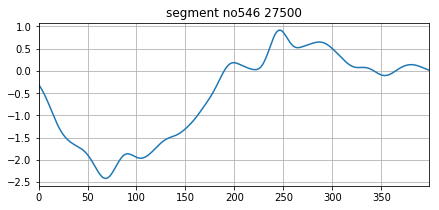

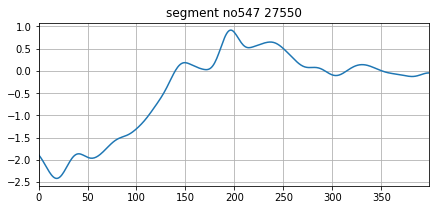

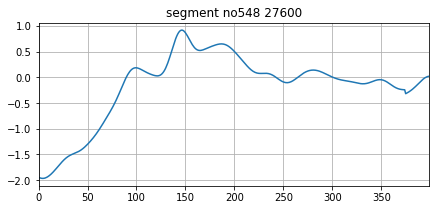

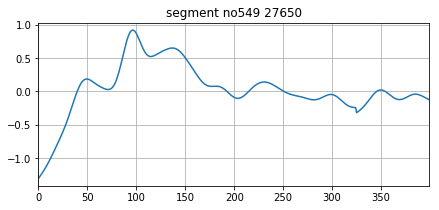

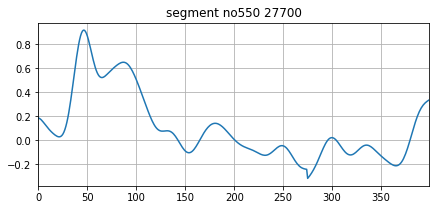

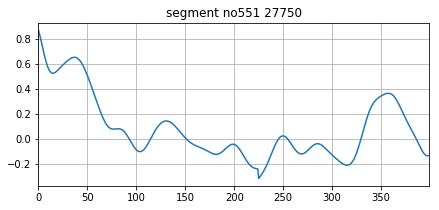

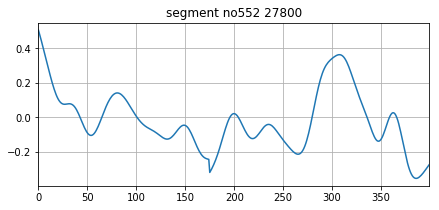

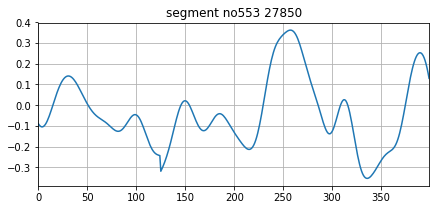

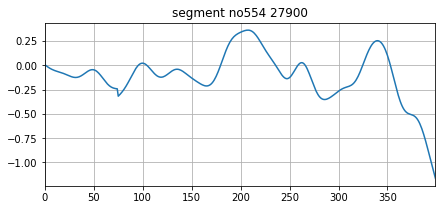

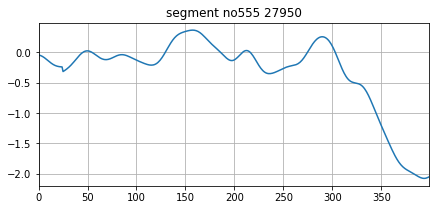

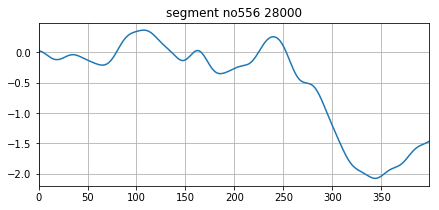

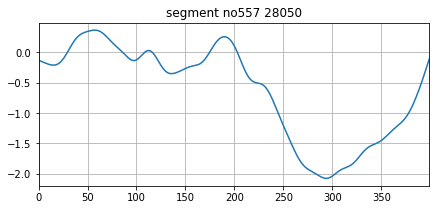

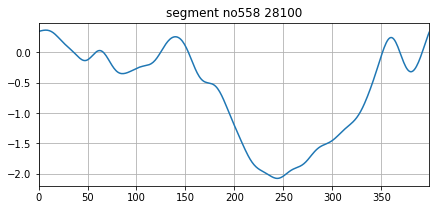

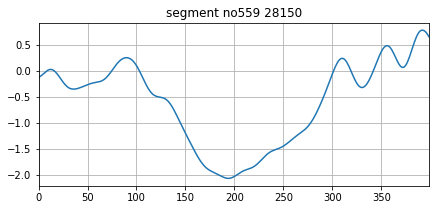

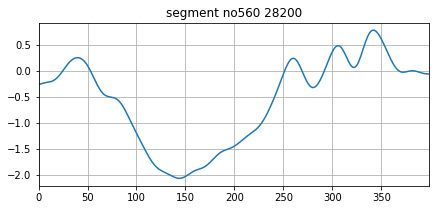

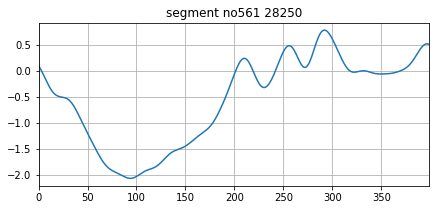

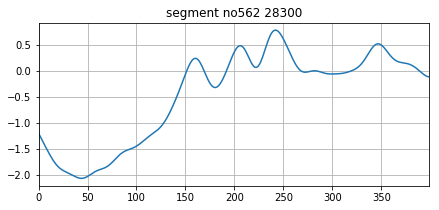

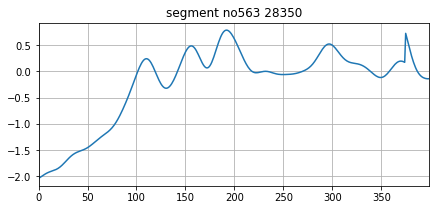

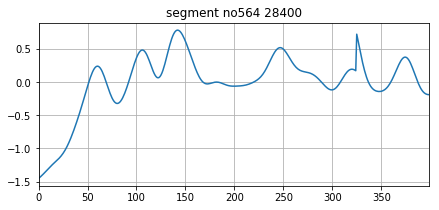

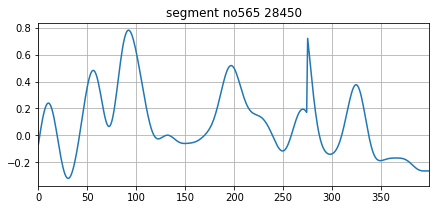

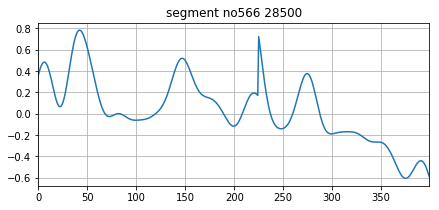

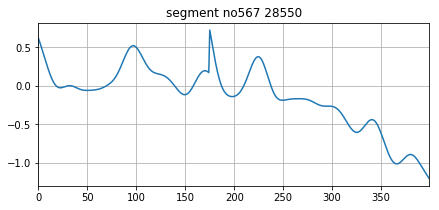

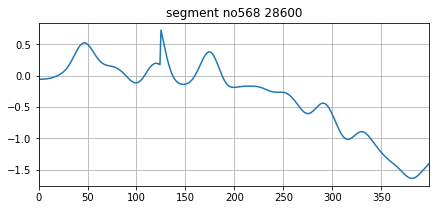

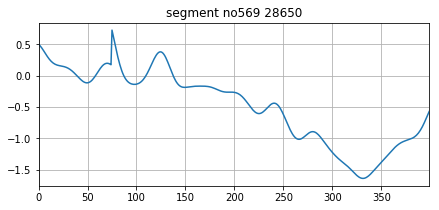

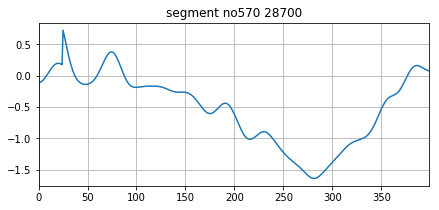

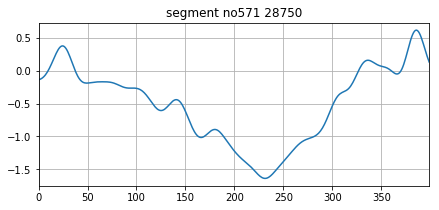

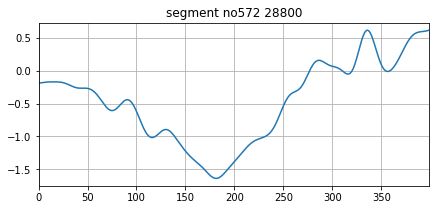

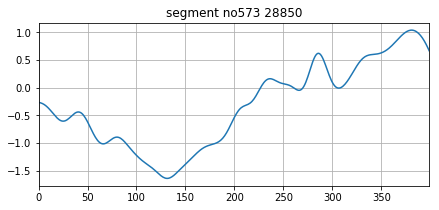

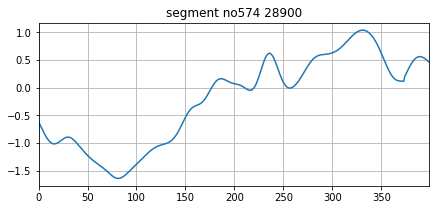

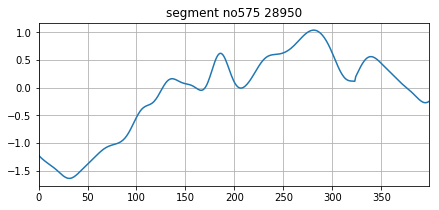

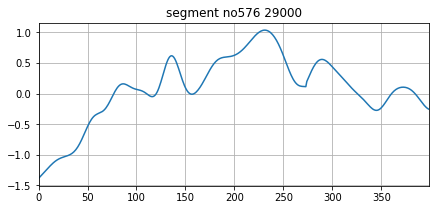

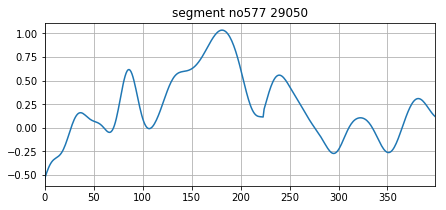

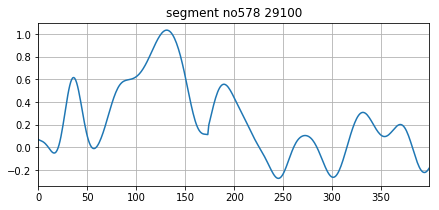

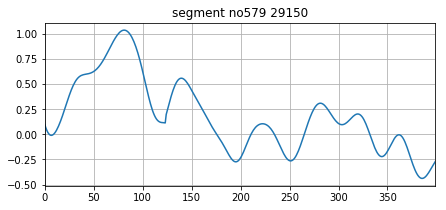

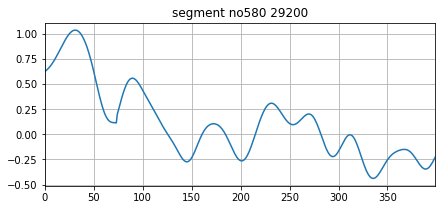

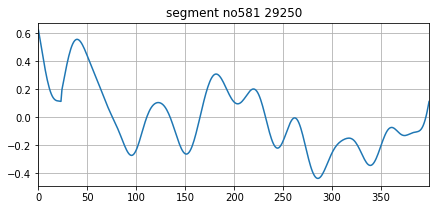

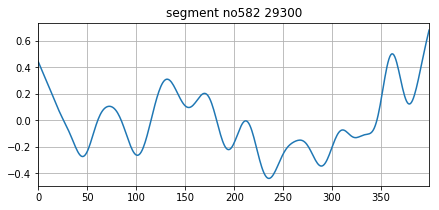

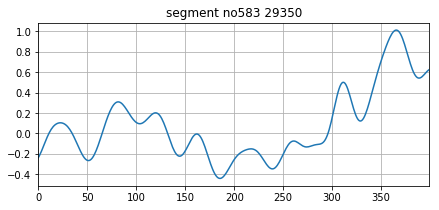

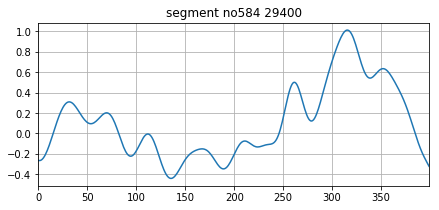

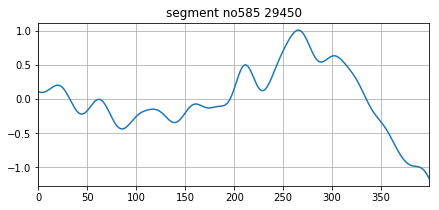

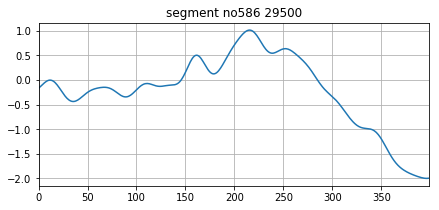

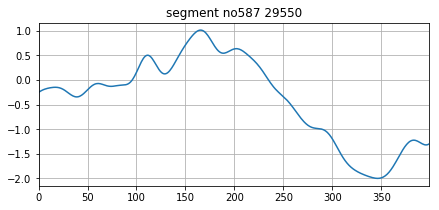

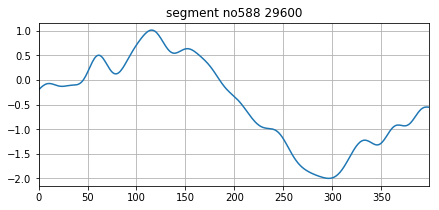

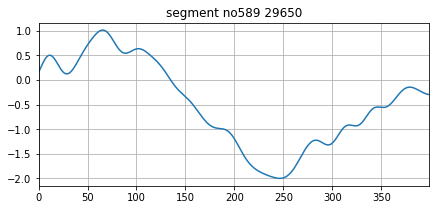

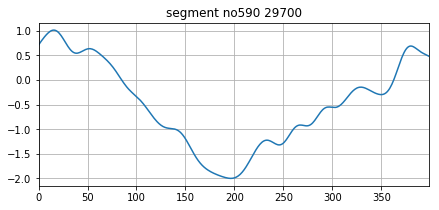

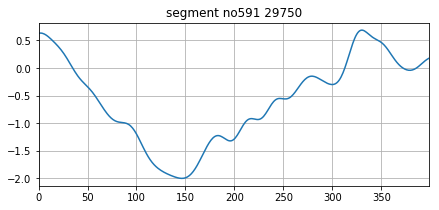

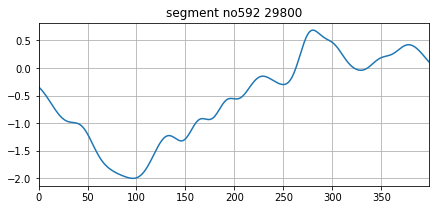

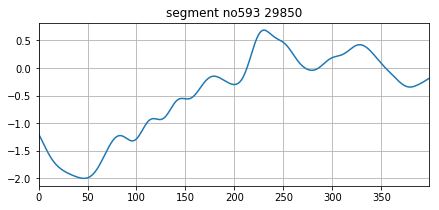

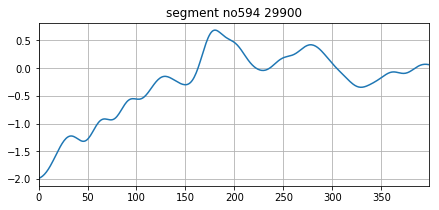

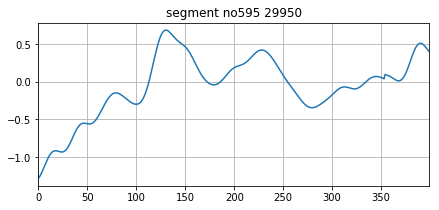

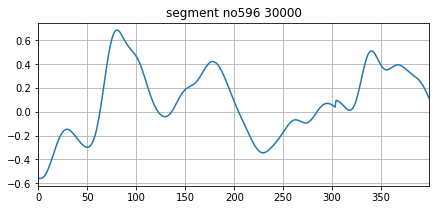

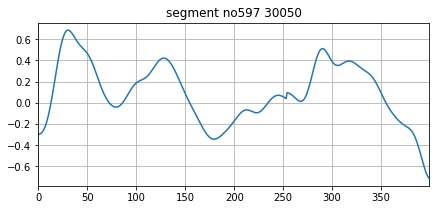

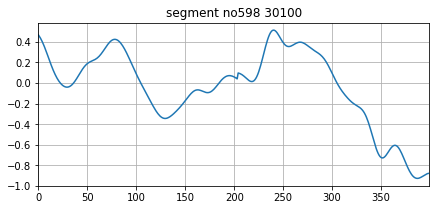

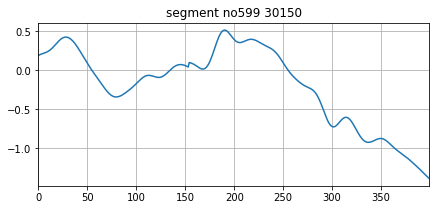

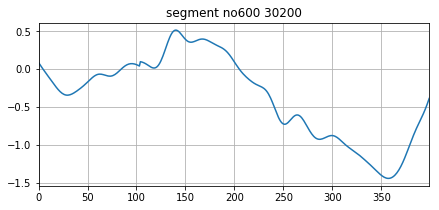

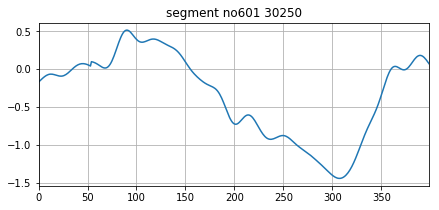

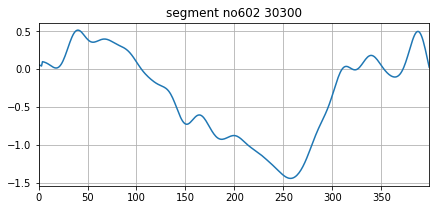

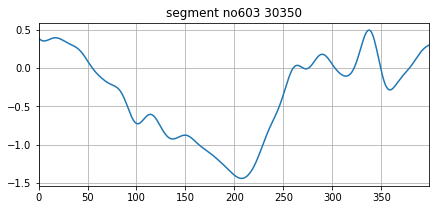

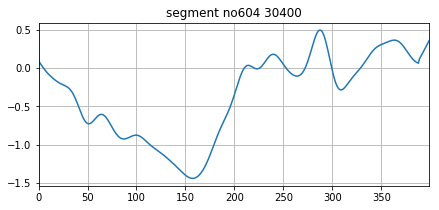

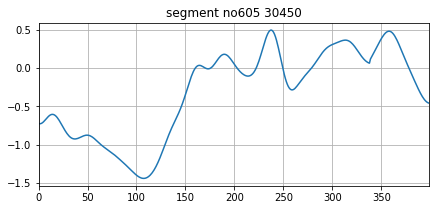

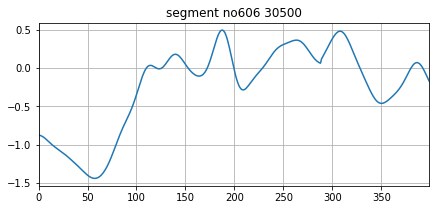

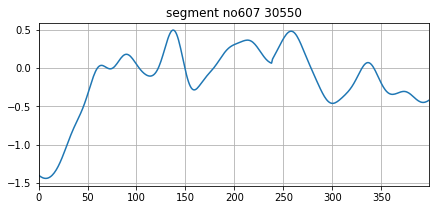

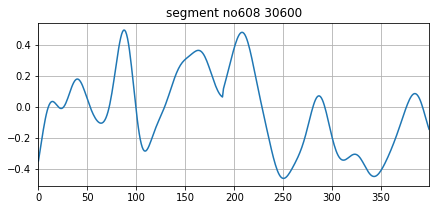

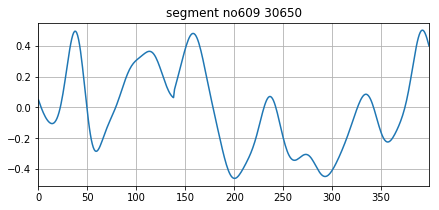

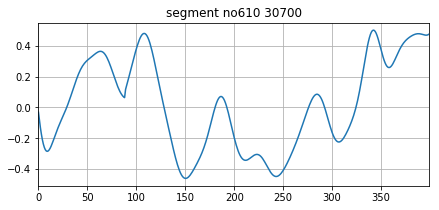

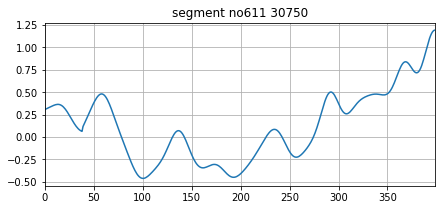

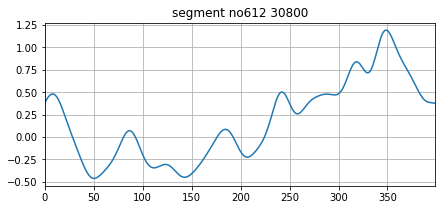

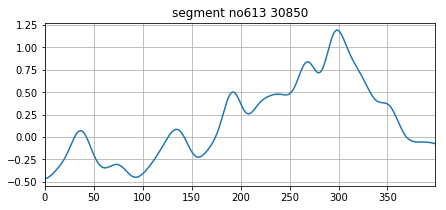

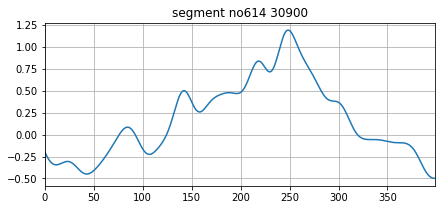

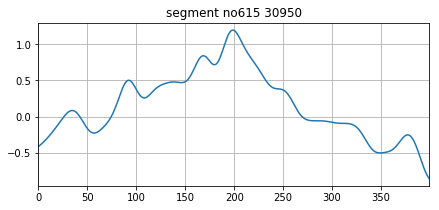

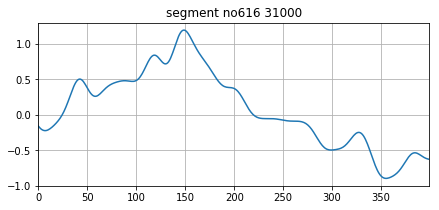

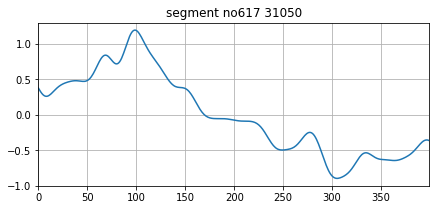

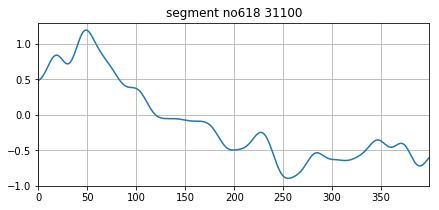

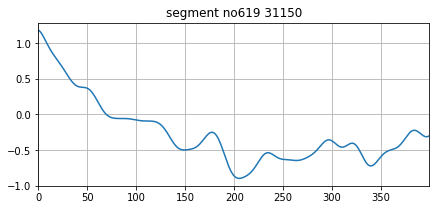

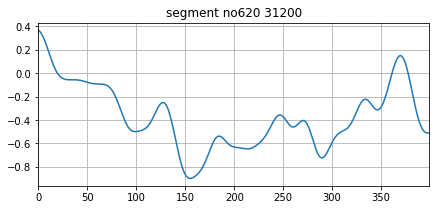

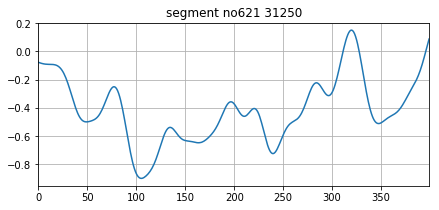

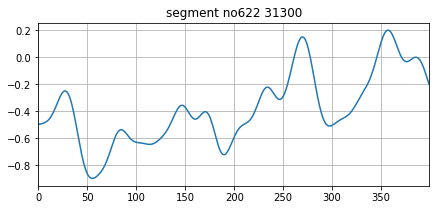

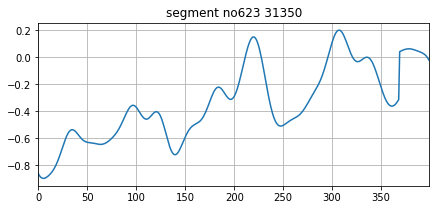

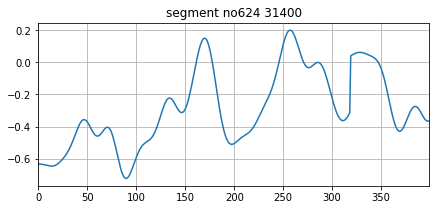

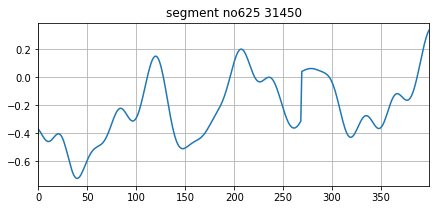

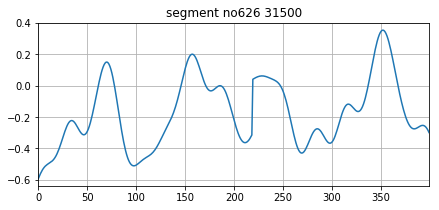

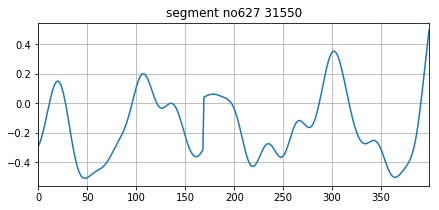

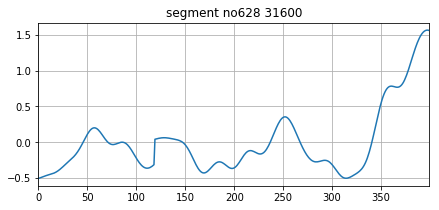

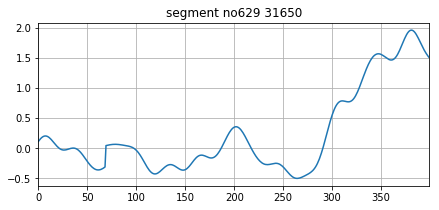

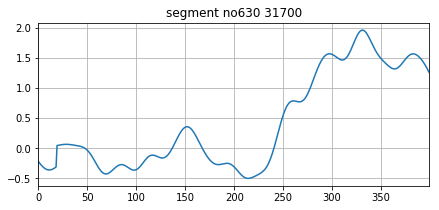

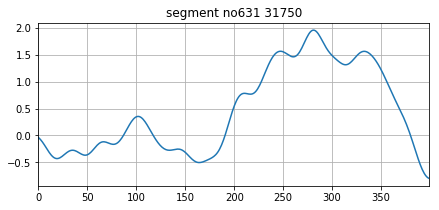

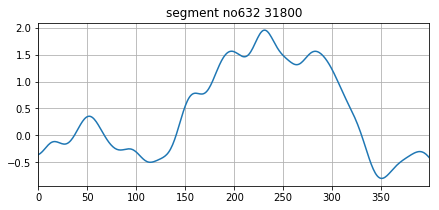

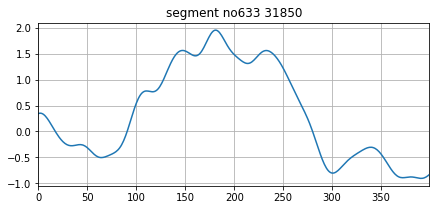

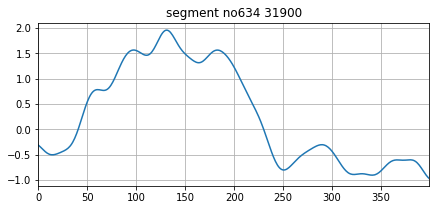

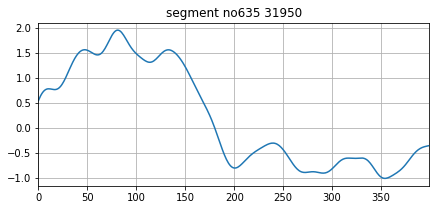

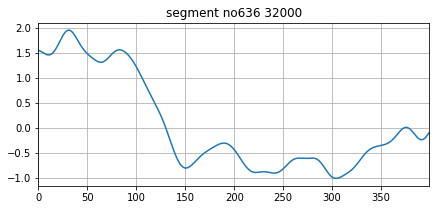

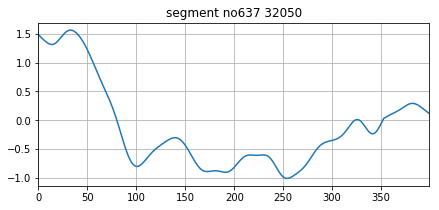

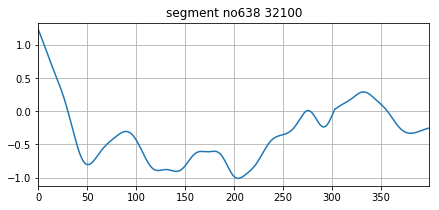

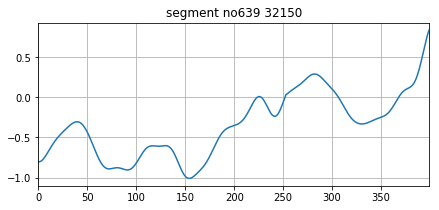

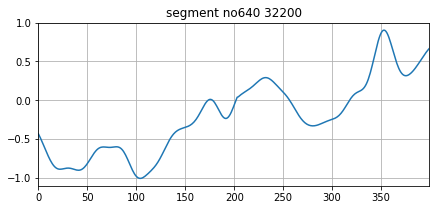

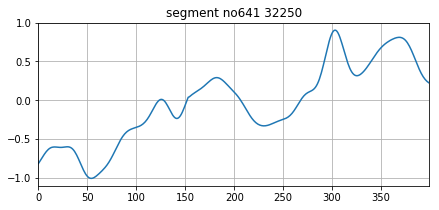

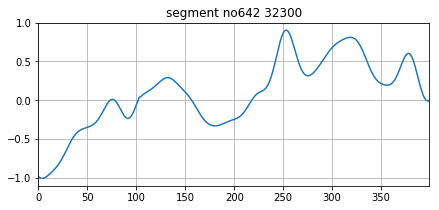

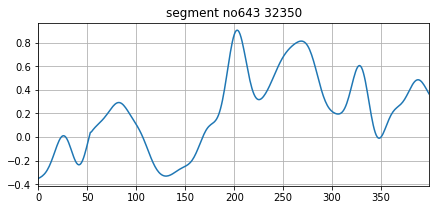

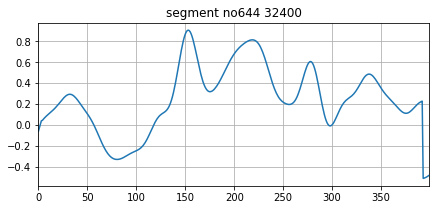

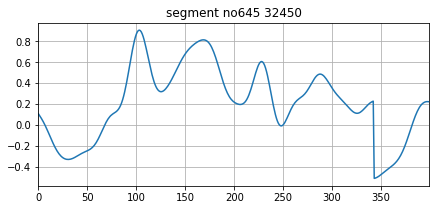

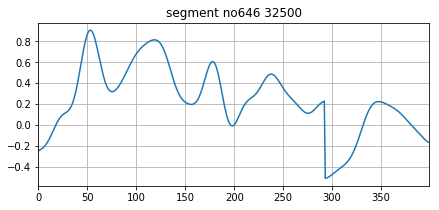

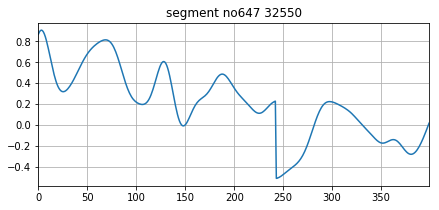

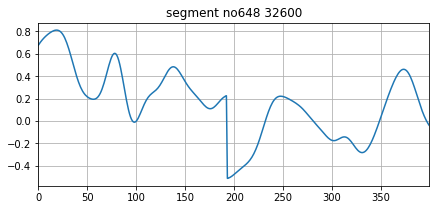

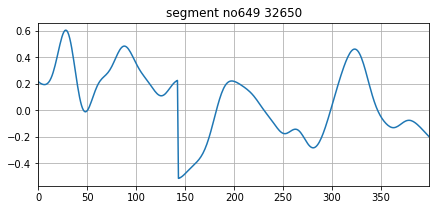

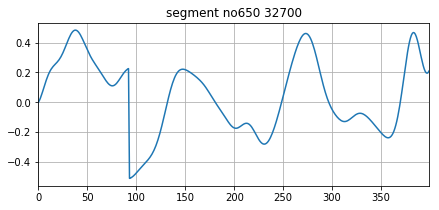

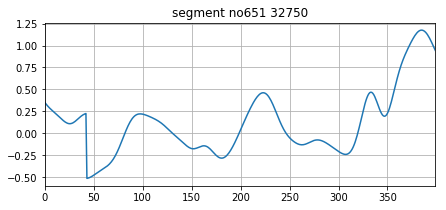

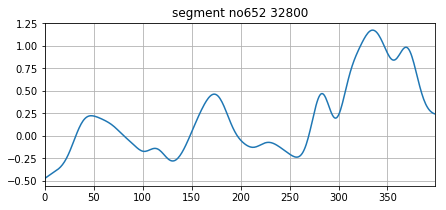

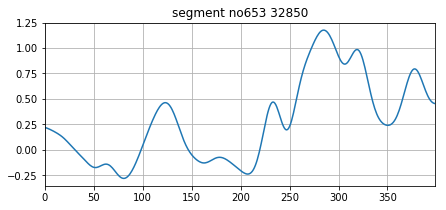

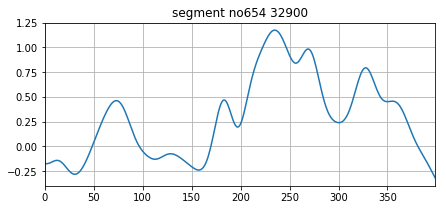

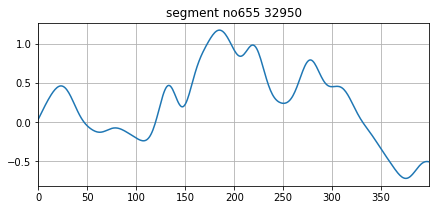

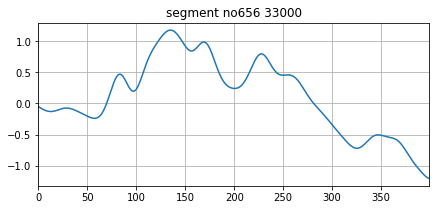

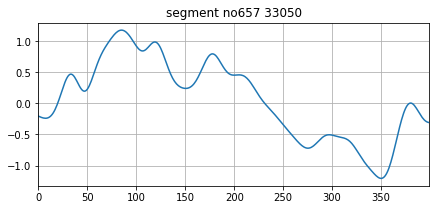

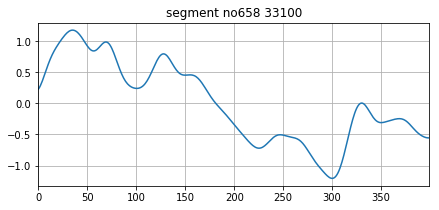

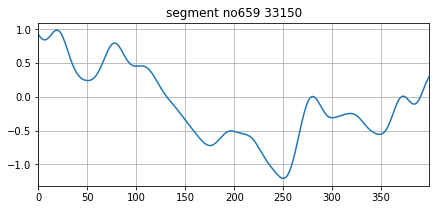

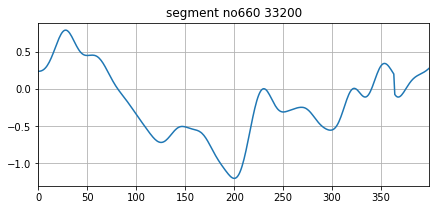

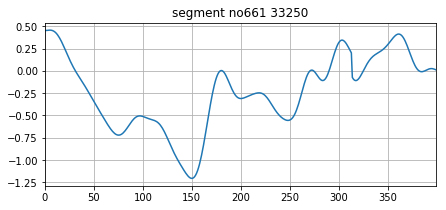

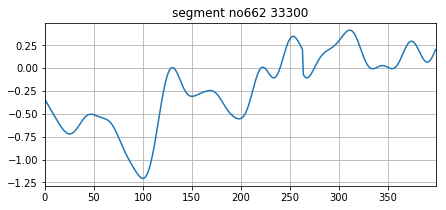

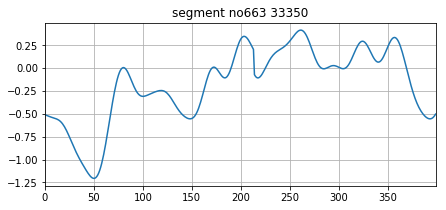

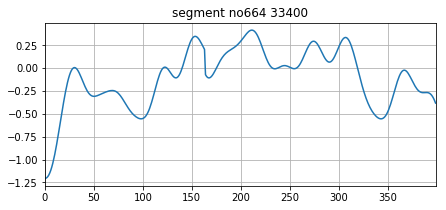

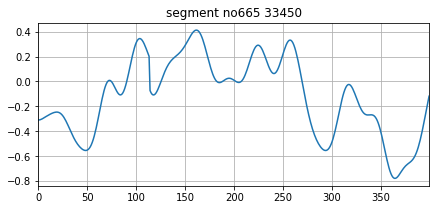

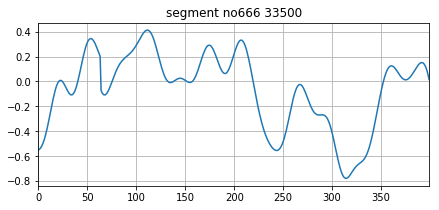

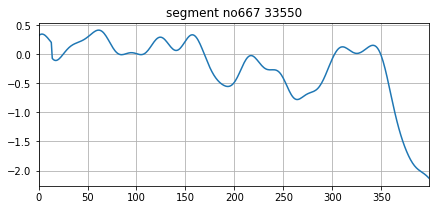

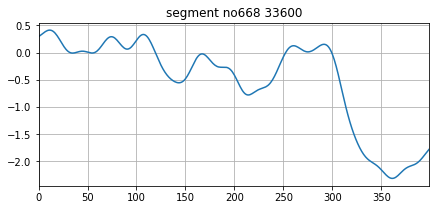

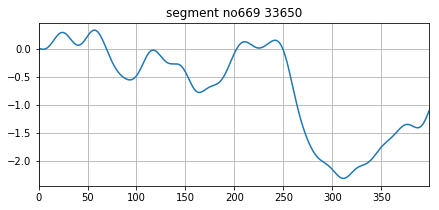

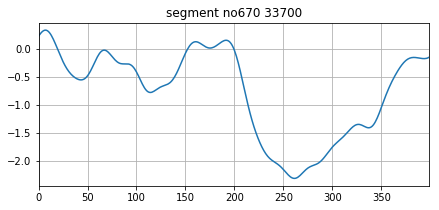

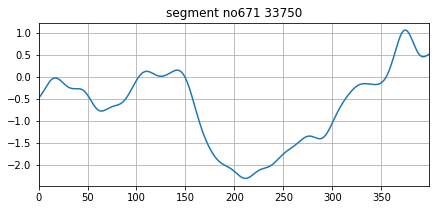

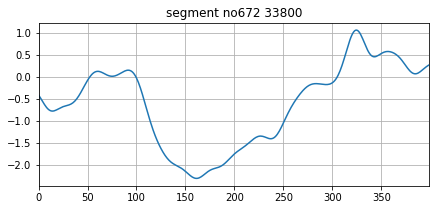

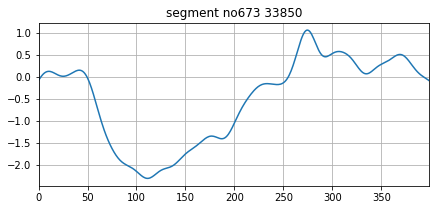

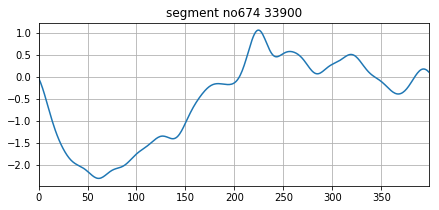

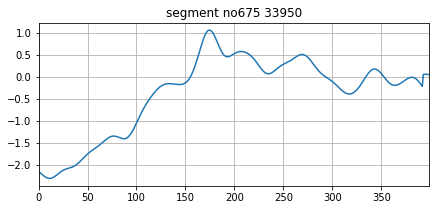

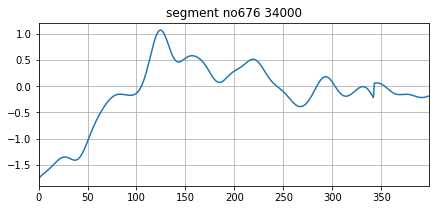

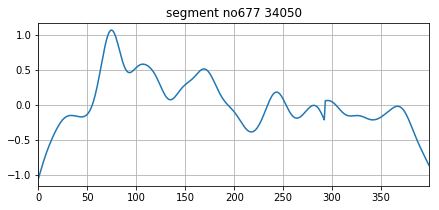

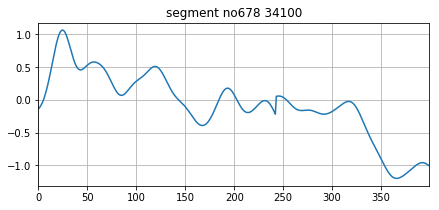

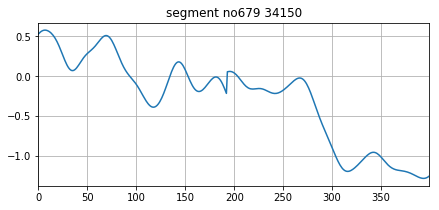

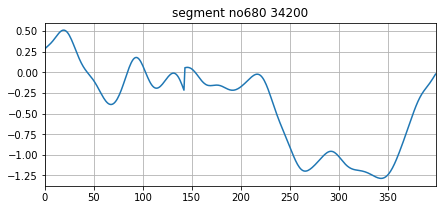

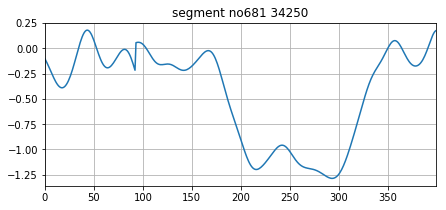

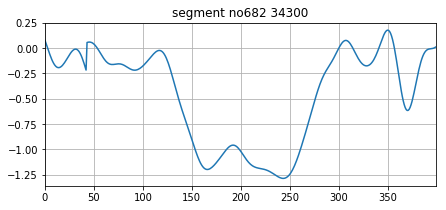

In [27]:
car_segments, car_labels = segmentation(df, 400)
np.array(car_segments).shape


(683, 6, 400)

In [28]:
def DTWdistance(segments, ref_seg_no):
    y = segments
    DTW_list = []
    for i in range(len(segments[1])):
        x = segments[ref_seg_no][i]
        diff = loss_for_segments(y, x, i)
        DTW_list.append(diff)
    
    return DTW_list
        

In [ ]:
ref_seq_no = 603
dtw_data = DTWdistance(car_segments, ref_seq_no)

0 => 8.60756736807
1 => 6.65641325442
2 => 6.10526608959
3 => 6.54506695154
4 => 8.34029453983
5 => 9.81746401096
6 => 9.24292481574
7 => 6.00333098126
8 => 7.70475967299
9 => 10.8466261414
10 => 12.7718589672
11 => 11.4744985867
12 => 11.5239973826
13 => 10.5479025354
14 => 8.95418860162
15 => 8.54589490737
16 => 6.68882298045
17 => 6.0653401241
18 => 6.50290241803
19 => 8.2080473907
20 => 9.67585738981
21 => 9.41946149639
22 => 6.10221006208
23 => 8.08217220163
24 => 10.3847780597
25 => 12.7566898604
26 => 11.657685769
27 => 10.6371763565
28 => 11.5513048456
29 => 14.3613762863
30 => 17.9789534462
31 => 17.1558636963
32 => 16.0320015914
33 => 16.714404391
34 => 18.3290294338
35 => 20.7211804702
36 => 19.2710461845
37 => 15.6083107839
38 => 10.1419801553
39 => 5.20021066517
40 => 4.50457205585
41 => 6.78155984343
42 => 11.8572550413
43 => 13.3186191589
44 => 17.9232498679
45 => 16.9472668647
46 => 15.9082604456
47 => 12.6075716229
48 => 9.54260504773
49 => 8.73989184022
50 => 9.081245

398 => 18.1620008793
399 => 17.301871927
400 => 17.5827713919
401 => 17.5697830332
402 => 15.817709634
403 => 14.6098100702
404 => 14.9926297835
405 => 16.3585528616
406 => 18.5287899087
407 => 20.582250213
408 => 19.2686442122
409 => 16.9103314086
410 => 14.6361556975
411 => 12.2108360205
412 => 10.4709442855
413 => 8.28570657299
414 => 5.4716719738
415 => 7.7716078007
416 => 9.67499506431
417 => 13.528452161
418 => 17.2858178054
419 => 18.5548644333
420 => 20.0248548661
421 => 18.9907590214
422 => 14.0328173241
423 => 10.6935685301
424 => 7.89368469837
425 => 4.3187077158
426 => 5.57449157524
427 => 9.25304411849
428 => 12.9053120075
429 => 12.8433918232
430 => 9.75643012234
431 => 7.17419751869
432 => 9.25629167739
433 => 11.3950566447
434 => 13.5517823732
435 => 16.7385337577
436 => 16.4367493058
437 => 15.774460594
438 => 16.9141167803
439 => 13.3918486781
440 => 8.8648927192
441 => 4.41150790339
442 => 6.07261618522
443 => 9.74290512826
444 => 8.62091086097
445 => 7.48081278254
4

113 => 6.87075283845
114 => 10.9965939973
115 => 11.1620203834
116 => 10.5259105646
117 => 16.7409364957
118 => 18.6992763169
119 => 15.7561811214
120 => 9.71904700313
121 => 4.94253660056
122 => 4.64849463173
123 => 6.5239004241
124 => 13.2804828281
125 => 16.3032240336
126 => 14.8756368385
127 => 10.6636159772
128 => 7.08633555412
129 => 8.0509047961
130 => 9.85790421999
131 => 13.861341382
132 => 13.7194497973
133 => 12.12335518
134 => 15.6019103248
135 => 17.7580188191
136 => 14.2480108891
137 => 10.4258170578
138 => 7.60412401169
139 => 5.89664692982
140 => 7.97660746937
141 => 9.86563477262
142 => 9.90268530233
143 => 7.55959228639
144 => 7.58143154187
145 => 6.9815755593
146 => 12.0123083977
147 => 16.5017279475
148 => 19.2844324795
149 => 18.0194927217
150 => 13.4213375158
151 => 9.85934241867
152 => 6.80439270907
153 => 4.42769758821
154 => 6.48529479992
155 => 7.64013347885
156 => 9.84379708172
157 => 7.91768939684
158 => 10.6928678977
159 => 15.7992655839
160 => 15.112670289

507 => 10.7184863552
508 => 10.5902400133
509 => 12.5719762095
510 => 15.7748816863
511 => 20.4635246096
512 => 22.1380434475
513 => 22.9138304482
514 => 17.7094162192
515 => 14.4759309986
516 => 12.3311225265
517 => 7.59676764239
518 => 6.28458083404
519 => 6.16738814908
520 => 8.16689238976
521 => 9.50762727045
522 => 12.4949072003
523 => 11.5978192001
524 => 14.2188840025
525 => 16.6405708649
526 => 13.8663364917
527 => 8.43154317724
528 => 4.08387474935
529 => 3.29893831602
530 => 7.1055211311
531 => 11.7022873889
532 => 11.0514109337
533 => 10.8604207707
534 => 13.0717013646
535 => 15.2895869023
536 => 12.6503595725
537 => 12.3194973562
538 => 12.4991712176
539 => 15.3330125461
540 => 18.9996672026
541 => 17.031425874
542 => 11.6398690324
543 => 5.93499229596
544 => 3.12680698778
545 => 3.45454262505
546 => 10.3134885194
547 => 12.8033187025
548 => 14.0747860655
549 => 16.0523651812
550 => 16.1544220392
551 => 15.1360526659
552 => 12.765521391
553 => 9.56572164784
554 => 10.739788

222 => 13.3951045553
223 => 11.6499861317
224 => 13.776069386
225 => 16.5010939464
226 => 18.8643168232
227 => 16.9015419237
228 => 10.414864733
229 => 4.51504812868
230 => 7.02309317294
231 => 11.7172834449
232 => 22.2658041338
233 => 21.5305431368
234 => 19.1866444652
235 => 14.9898912979
236 => 11.6967528474
237 => 11.380529779
238 => 12.7768370354
239 => 12.5156676885
240 => 8.84717790142
241 => 7.95633062184
242 => 9.50764557408
243 => 12.6451113669
244 => 13.8698951453
245 => 20.2668978981
246 => 22.1162020232
247 => 23.3709856717
248 => 18.0179692466
249 => 10.1152808898
250 => 7.06610262734
251 => 4.5388405134
252 => 9.38368508036
253 => 15.8642235733
254 => 14.3431870183
255 => 12.8344749274
256 => 15.2314141835
257 => 20.1905498081
258 => 21.0461163332
259 => 19.2670866612
260 => 13.5504897655
261 => 7.23910730869
262 => 5.45110763735
263 => 8.78588707657
264 => 10.3556244531
265 => 10.8824855996
266 => 9.83561804753
267 => 10.3281198139
268 => 10.871314701
269 => 12.09147122

616 => 18.4320449147
617 => 14.2556482577
618 => 10.8492092916
619 => 7.50921894756
620 => 5.60265751588
621 => 6.42485522731
622 => 7.48207466018
623 => 10.2601915715
624 => 10.678102277
625 => 9.79941838614
626 => 11.4942597643
627 => 9.8833773218
628 => 11.5342471457
629 => 15.8780364388
630 => 17.6629161491
631 => 17.3316447208
632 => 22.7800458094
633 => 28.45955647
634 => 25.6367040513
635 => 20.3990618104
636 => 14.7674452482
637 => 8.74214817984
638 => 4.39395437103
639 => 7.05827820922
640 => 11.083309748
641 => 13.9935898505
642 => 13.0735628565
643 => 12.7942559273
644 => 16.5779385591
645 => 17.7033021804
646 => 15.6663661513
647 => 13.6317921487
648 => 10.5261899618
649 => 9.15110774264
650 => 11.2596559864
651 => 11.437782927
652 => 13.7177641467
653 => 12.8216384911
654 => 14.3387176124
655 => 18.7265572448
656 => 21.100005631
657 => 17.8696652533
658 => 12.6551716549
659 => 6.12890990263
660 => 2.81337981259
661 => 5.34992197967
662 => 9.30968618218
663 => 12.01739555
6

331 => 2.50583005417
332 => 2.18150088017
333 => 2.07603637628
334 => 2.22565300337
335 => 1.81097002249
336 => 1.81141466736
337 => 2.01110310937
338 => 2.29093523104
339 => 2.36805647457
340 => 1.69258620174
341 => 1.38343303774
342 => 2.00723915381
343 => 1.35262462678
344 => 1.57594532923
345 => 1.66944572696
346 => 1.91066602784
347 => 2.45210566969
348 => 1.78407009971
349 => 1.95397685481
350 => 2.01317841613
351 => 1.64703600469
352 => 1.57381826489
353 => 1.94061407438
354 => 1.81204434398
355 => 2.08405916277
356 => 1.86072446559
357 => 2.02675624493
358 => 1.83421415876
359 => 2.01346111425
360 => 1.09273749147
361 => 1.03609745095
362 => 1.7775142899
363 => 2.73081810266
364 => 3.3055269949
365 => 3.19836943961
366 => 3.37639156289
367 => 2.63097856492
368 => 2.31527674023
369 => 2.15186236636
370 => 1.93006908316
371 => 1.70419037912
372 => 1.67231701201
373 => 1.94876589167
374 => 2.13194096338
375 => 2.20599823059
376 => 2.64005502269
377 => 2.50490044318
378 => 2.642216

42 => 3.51691191844
43 => 3.46134557997
44 => 3.84619623235
45 => 3.48951731834
46 => 3.09172647733
47 => 3.15238996951
48 => 2.85204614077
49 => 2.7804377957
50 => 3.00323749508
51 => 2.70645596272
52 => 2.62593926897
53 => 3.17385740675
54 => 3.55203150644
55 => 3.89737467945
56 => 4.30094086435
57 => 4.35269083602
58 => 3.97345775818
59 => 3.32623734274
60 => 3.08650833569
61 => 2.82901635601
62 => 2.67224480559
63 => 2.72045887389
64 => 2.98393652217
65 => 2.98697616833
66 => 3.2486115561
67 => 2.91592580821
68 => 1.71469208789
69 => 0.663523963046
70 => 1.0635927107
71 => 1.88041333529
72 => 3.34350108841
73 => 4.25143191818
74 => 3.86192190633
75 => 3.09030930465
76 => 2.8404735752
77 => 2.86699943094
78 => 3.01446471582
79 => 3.08597276247
80 => 2.59819375795
81 => 1.31535179736
82 => 0.911948728099
83 => 0.939375107334
84 => 2.05192284527
85 => 3.42078750069
86 => 3.49825763052
87 => 3.29923752466
88 => 2.79379292836
89 => 2.78597577026
90 => 2.63699786537
91 => 2.97352285629
9

In [462]:
ref_seq_no = 361
dtw_data_RT = DTWdistance(car_segments, ref_seq_no)

0 => 11.9697148935
1 => 11.3140554958
2 => 10.3390884133
3 => 9.02459641665
4 => 9.47585676537
5 => 8.19385084767
6 => 7.36655468687
7 => 7.25718761332
8 => 5.42092691378
9 => 4.51882917401
10 => 5.51477929899
11 => 6.47749256274
12 => 8.03615251415
13 => 8.22327596234
14 => 10.0667147631
15 => 11.9598989216
16 => 11.3345185956
17 => 10.3449875799
18 => 9.09970514669
19 => 9.42812817718
20 => 8.23774086061
21 => 7.47915915538
22 => 7.08507741433
23 => 5.50378564
24 => 8.88934608342
25 => 9.31667480212
26 => 9.01238969853
27 => 8.20655111972
28 => 8.55163311341
29 => 7.00872095975
30 => 8.69237785312
31 => 8.49503842652
32 => 8.71502152369
33 => 5.69050586904
34 => 4.84990821837
35 => 6.41962817371
36 => 10.5890247652
37 => 14.3790751092
38 => 18.1110818608
39 => 17.4586997168
40 => 16.8702773475
41 => 14.1988490048
42 => 11.6707808219
43 => 5.03478865348
44 => 5.05177795661
45 => 6.12052749792
46 => 9.41613352054
47 => 9.19271053868
48 => 10.0945073687
49 => 10.5605681049
50 => 10.2535

112 => 17.8366946538
113 => 19.0473804549
114 => 14.3111771836
115 => 12.9530937686
116 => 10.1237106509
117 => 8.40388801455
118 => 9.08993534155
119 => 12.4632290059
120 => 20.2164847595
121 => 23.9482235103
122 => 22.2622134893
123 => 18.3980357024
124 => 12.3368283258
125 => 8.21328343204
126 => 9.39136849639
127 => 12.5567613296
128 => 14.5478992253
129 => 11.1510308651
130 => 13.0375339115
131 => 13.6711446153
132 => 10.2491099348
133 => 6.36345659433
134 => 10.0593180138
135 => 9.41729145866
136 => 12.5478238239
137 => 14.3039727955
138 => 20.1127362016
139 => 16.6315277295
140 => 15.1100915467
141 => 13.6198144058
142 => 14.2361749969
143 => 17.1170017936
144 => 16.8704634363
145 => 14.0117729244
146 => 10.0370761211
147 => 2.62589670976
148 => 2.42192979678
149 => 8.54349712066
150 => 15.430460567
151 => 15.5113076211
152 => 18.6229080522
153 => 15.6714257361
154 => 15.2779420957
155 => 13.648619417
156 => 12.3259782174
157 => 13.3683204818
158 => 8.83301359909
159 => 7.993100

507 => 16.0945327747
508 => 15.3563145821
509 => 16.5815344348
510 => 14.8527496488
511 => 8.30095827823
512 => 5.68843969753
513 => 9.1707228311
514 => 16.1329538554
515 => 13.046914593
516 => 19.1395397646
517 => 15.1951974225
518 => 14.8068947756
519 => 11.678930053
520 => 10.3606047494
521 => 12.214545076
522 => 10.8133029309
523 => 7.29748811927
524 => 8.35113334132
525 => 9.05858427893
526 => 10.9818714602
527 => 15.1595386992
528 => 17.6169220447
529 => 16.4354784365
530 => 14.7006244707
531 => 12.6439259069
532 => 10.7004574883
533 => 8.38013382255
534 => 8.38088174655
535 => 8.75619188705
536 => 13.2010905002
537 => 12.3829104518
538 => 12.1537452943
539 => 6.81236736693
540 => 9.85296184747
541 => 10.2840736792
542 => 13.6779854191
543 => 22.0234223346
544 => 20.6834504052
545 => 19.0655835725
546 => 14.3134282604
547 => 11.6819899042
548 => 10.1329271707
549 => 7.41859585473
550 => 6.82325081043
551 => 11.0697271684
552 => 12.2717189237
553 => 12.5712168559
554 => 10.8376104

223 => 12.6005800106
224 => 13.6594420775
225 => 16.2373456051
226 => 19.6392754142
227 => 24.4427103066
228 => 28.9807084015
229 => 29.6600571327
230 => 28.904678796
231 => 23.6921014472
232 => 16.6480556453
233 => 10.1761852909
234 => 8.75492414107
235 => 10.341469014
236 => 10.0923811986
237 => 11.7819191398
238 => 12.3689287637
239 => 12.5002040589
240 => 15.028388015
241 => 17.6905877776
242 => 16.7642677089
243 => 15.6001497587
244 => 11.0284914302
245 => 5.17297785772
246 => 4.90677570813
247 => 8.94459493649
248 => 17.1603668235
249 => 20.3121247674
250 => 24.4687553163
251 => 22.418087585
252 => 17.7234896934
253 => 18.1737305895
254 => 15.2414499691
255 => 12.3562506005
256 => 9.38181879846
257 => 3.90718708463
258 => 3.68819566776
259 => 8.55904822756
260 => 15.5718374473
261 => 16.4035518784
262 => 17.95583801
263 => 17.1698987404
264 => 14.8560257306
265 => 15.6222913809
266 => 16.2000583643
267 => 17.9510560256
268 => 14.6501957445
269 => 11.7466475614
270 => 8.3240570825

617 => 13.1367712713
618 => 17.2248604286
619 => 20.6240597324
620 => 21.2618567655
621 => 20.0421825062
622 => 17.6618584411
623 => 16.718786395
624 => 14.3433675682
625 => 13.5719751926
626 => 14.1368730506
627 => 13.7605785728
628 => 16.5213484837
629 => 21.1838199611
630 => 18.7018073715
631 => 10.5298879222
632 => 8.58721293457
633 => 7.11530478151
634 => 10.6334576262
635 => 18.018761832
636 => 24.8148063741
637 => 25.5329295216
638 => 21.0677493434
639 => 18.1716345274
640 => 15.9879378072
641 => 12.9991171871
642 => 9.35408208539
643 => 10.1954314394
644 => 5.44103631795
645 => 6.02966447552
646 => 6.99900987388
647 => 11.2005854988
648 => 13.1198927755
649 => 12.321995423
650 => 12.7119367044
651 => 14.064943867
652 => 13.0096028111
653 => 10.1232933548
654 => 7.92325908555
655 => 6.11261129909
656 => 4.6467066558
657 => 9.57764134595
658 => 15.857977467
659 => 19.7768933435
660 => 19.7100955564
661 => 18.7653419866
662 => 14.8575710356
663 => 12.3425496229
664 => 10.416159383

331 => 3.01206973744
332 => 2.61596279877
333 => 2.5812945974
334 => 2.93428793381
335 => 2.53387318193
336 => 2.67705854219
337 => 2.8566160568
338 => 2.70027684284
339 => 3.06980816349
340 => 2.13747535897
341 => 2.15694926134
342 => 2.79011426193
343 => 2.01631791375
344 => 2.33179166871
345 => 2.06887676307
346 => 2.45704476789
347 => 3.09371543068
348 => 1.86389519003
349 => 2.59268983242
350 => 2.26259541252
351 => 2.51513941131
352 => 2.52689412883
353 => 2.65256899877
354 => 2.60198158893
355 => 2.78253014317
356 => 2.48577334696
357 => 2.71847277882
358 => 2.44623571972
359 => 1.91135780997
360 => 0.585813615041
361 => 0.0
362 => 0.777578518089
363 => 2.13936669926
364 => 2.65682346189
365 => 3.36789975059
366 => 3.29323454215
367 => 3.26066420402
368 => 2.52973429014
369 => 2.87957231869
370 => 2.63645430877
371 => 2.52012573758
372 => 2.56510134242
373 => 2.48458734977
374 => 2.88123713709
375 => 2.82567606253
376 => 3.38053711527
377 => 3.06168745282
378 => 3.58345068406
37

43 => 1.95303981351
44 => 1.87281386296
45 => 1.68832540832
46 => 1.56119376859
47 => 1.70076485743
48 => 1.32089505793
49 => 1.26546485655
50 => 1.30858947375
51 => 1.24262229149
52 => 1.59359532644
53 => 2.28182165686
54 => 2.36931116164
55 => 2.66605440808
56 => 2.39453985031
57 => 2.36679854638
58 => 2.14650374182
59 => 2.01426307548
60 => 1.96116534716
61 => 1.74736066314
62 => 1.75438606647
63 => 1.3335340217
64 => 1.23191670039
65 => 1.10495994948
66 => 1.60111332189
67 => 1.39166598167
68 => 1.85737780085
69 => 1.50327386799
70 => 2.30166955697
71 => 2.7715446533
72 => 2.43831185197
73 => 3.06406156304
74 => 1.96651254717
75 => 1.55600239388
76 => 1.47211100546
77 => 1.22757337261
78 => 1.01758945501
79 => 1.43384765333
80 => 1.35118485238
81 => 1.78089146172
82 => 1.40310048756
83 => 1.8867261006
84 => 2.22728461811
85 => 2.25101283709
86 => 2.66327537262
87 => 1.74590652726
88 => 1.34655013625
89 => 1.01579171607
90 => 1.05496554366
91 => 0.933174042728
92 => 0.839424985245
9

149 => 0.824750917297
150 => 0.905030694333
151 => 1.12348498876
152 => 2.18205130493
153 => 2.34016946775
154 => 2.09723759539
155 => 1.51138520221
156 => 1.37041837882
157 => 1.64921798709
158 => 1.32386099665
159 => 1.42820331756
160 => 1.80785011203
161 => 1.69673972849
162 => 1.695069087
163 => 1.75631508022
164 => 1.41996344647
165 => 1.49581089812
166 => 0.770133443929
167 => 1.96875832757
168 => 2.26230286439
169 => 2.18054715507
170 => 2.22317916726
171 => 2.14313671744
172 => 2.65553721862
173 => 2.46910587322
174 => 2.23644647228
175 => 2.62623502409
176 => 2.584701728
177 => 2.18100840155
178 => 2.21342220742
179 => 2.21347883877
180 => 1.96252603366
181 => 2.02908976999
182 => 1.96933074697
183 => 2.29282363878
184 => 2.13298311691
185 => 2.00987827515
186 => 1.87892728096
187 => 2.91785872509
188 => 2.058238261
189 => 1.80857687923
190 => 2.29359512157
191 => 1.95188934339
192 => 1.92350382513
193 => 2.09043663136
194 => 1.95180662174
195 => 1.75318215645
196 => 2.8418166

541 => 1.61190640973
542 => 1.92262178771
543 => 1.65870584763
544 => 1.82540228021
545 => 1.90949866835
546 => 1.59584810234
547 => 1.46117636282
548 => 1.72471563473
549 => 1.65308458574
550 => 1.34219335907
551 => 1.6210326544
552 => 1.33704370766
553 => 1.92494285319
554 => 2.51690139399
555 => 3.45540113959
556 => 2.70602603912
557 => 2.89406019827
558 => 2.61576026164
559 => 2.60277647931
560 => 2.46155904938
561 => 2.51420934954
562 => 2.38361453524
563 => 1.58845507852
564 => 1.87339316167
565 => 1.94542729794
566 => 1.13048462803
567 => 1.23419081549
568 => 1.47317408739
569 => 1.62889093482
570 => 1.71734224743
571 => 1.79410906114
572 => 1.61855867861
573 => 1.74719199255
574 => 1.24550385719
575 => 1.62867658489
576 => 1.7678557632
577 => 1.82686457294
578 => 1.35949229697
579 => 1.66009246858
580 => 1.35843202265
581 => 1.02939831227
582 => 0.886024503252
583 => 1.03465275299
584 => 0.995455149825
585 => 1.50861151536
586 => 1.55807103241
587 => 1.68138864538
588 => 1.1390

In [ ]:
ref_seq_no = 664
dtw_data_ST = DTWdistance(car_segments, ref_seq_no)

In [26]:

np.array(dtw_data).shape
train = [*zip(*dtw_data)]
np.array(train).shape

NameError: name 'dtw_data' is not defined

In [430]:
label = [0]*len(train)
label[2:7]=[1]*(7-2)
label[13:21]=[1]*(21-13)
label[52:57]=[1]*(57-52)
label[67:72]=[1]*(72-67)
label[89:92]=[1]*(92-89)
label[101:104]=[1]*(104-101)
label[110:115]=[1]*(115-110)
label[119:125]=[1]*(125-119)
label[160:167]=[1]*(167-160)
label[173:176]=[1]*(176-173)
label[196:202]=[1]*(202-196)
label[209:218]=[1]*(218-209)
label[226:233]=[1]*(233-226)
label[250:253]=[1]*(253-250)
label[270:274]=[1]*(274-270)
label[303:309]=[1]*(309-303)
label[326:334]=[1]*(334-326)
label[420:425]=[1]*(425-420)
label[446:453]=[1]*(453-446)
label[470:474]=[1]*(474-470)
label[477:482]=[1]*(482-477)
label[488:491]=[1]*(491-488)
label[526:532]=[1]*(532-526)
label[540:548]=[1]*(548-540)
label[555:563]=[1]*(563-555)
label[568:574]=[1]*(574-568)
label[588:594]=[1]*(594-588)
label[600:605]=[1]*(605-600)
label[620:624]=[1]*(624-620)
label[638:641]=[1]*(641-638)
label[659:662]=[1]*(662-659)
label[679:682]=[1]*(682-679)

In [431]:
print(len(train))
print(len(label))

683
683


683
683


In [432]:
label[7:13]  = [2]*(13-7)
label[22:24] = [2]*(24-22)
label[26:30] = [2]*(30-26)
label[40:44] = [2]*(44-40)
label[61:62] = [2]*(62-61)
label[81:84] = [2]*(84-81)
label[106:107] = [2]*(107-106)
label[133:135] = [2]*(135-133)
label[146:149] = [2]*(149-146)
label[181:183] = [2]*(183-181)
label[186:189] = [2]*(189-186)
label[242:247] = [2]*(247-242)
label[255:258] = [2]*(258-255)
label[290:294] = [2]*(294-290)
label[317:320] = [2]*(320-317)
label[344:349] = [2]*(349-344)
label[357:364] = [2]*(364-357)
label[375:381] = [2]*(381-375)
label[393:400] = [2]*(400-393)
label[406:408] = [2]*(408-406)
label[414:418] = [2]*(418-414)
label[433:437] = [2]*(437-433)
label[463:468] = [2]*(468-463)
label[511:514] = [2]*(514-511)
label[520:523] = [2]*(523-520)
label[584:586] = [2]*(586-584)
label[612:616] = [2]*(616-612)
label[629:636] = [2]*(636-629)
label[652:658] = [2]*(658-652)
label[668:675] = [2]*(675-668)


In [433]:
print(len(train))
print(len(label))

683
683


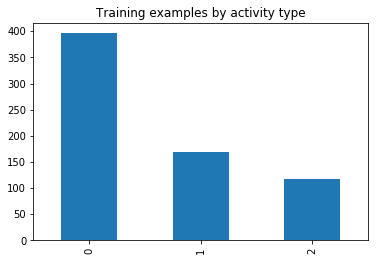

In [434]:
labels= pd.Series(label)
labels.value_counts().plot(kind='bar', title='Training examples by activity type')

In [453]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=RANDOM_SEED)

In [454]:

# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [455]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

[ 0.60909091  0.65454545  0.65137615  0.67889908  0.63888889] 0.646560096377 0.0227840195522


In [456]:

# apply model to test set
clf.fit(X_train, y_train)
predict_y = clf.predict(X_test)
print(predict_y)

[2 0 0 0 0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 0 2 0 0 2 0 2 0 1 2 0 1 0 0 0 0 0 2
 2 0 2 0 1 1 0 0 0 0 0 2 2 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 1 0 1 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 2 2 0 0 2 1 0 1 1 0 0 0 0 0 0 2 1 0 1 1 0 0 0 0 0]


In [457]:

# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.642


In [460]:
for i in range(len(predict_y)):
    print(y_test[i], " ", predict_y[i])
    print("-----")

2   2
-----
0   0
-----
1   0
-----
0   0
-----
0   0
-----
2   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   2
-----
1   1
-----
0   1
-----
0   0
-----
0   0
-----
1   0
-----
1   0
-----
0   0
-----
2   0
-----
2   2
-----
0   0
-----
2   0
-----
2   2
-----
0   0
-----
0   2
-----
1   0
-----
1   1
-----
0   2
-----
1   0
-----
1   1
-----
0   0
-----
1   0
-----
0   0
-----
0   0
-----
0   0
-----
2   2
-----
2   2
-----
0   0
-----
0   2
-----
0   0
-----
1   1
-----
1   1
-----
2   0
-----
0   0
-----
0   0
-----
1   0
-----
1   0
-----
2   2
-----
0   2
-----
0   0
-----
2   0
-----
2   0
-----
0   0
-----
2   0
-----
0   0
-----
1   1
-----
1   0
-----
1   1
-----
1   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   0
-----
0   0
-----
2   0
-----
0   0
-----
0   0
-----
0   0
-----
1   0
-----
0   0
-----
0   0
-----
0   0
-----
0   2
-----
1   1
-----
1   0
-----
1   1
-----
0   2
-----
1   1
-----
0   

In [447]:
svm_clf = svm.SVC(kernel='linear', C=1)

In [450]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
print(svm_scores, svm_scores.mean(), svm_scores.std())

[ 0.59090909  0.59090909  0.59633028  0.59633028  0.59259259] 0.593414264974 0.00245899049661


In [451]:
# apply model to test set
svm_clf.fit(X_train, y_train)
predict_y = svm_clf.predict(X_test)
print(predict_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [452]:
# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.526
